In [1]:
using Revise
includet("../../scripts/single_influx.jl")

Precompiling packages...
  34613.0 ms  ✓ SSMCMain
  1 dependency successfully precompiled in 41 seconds. 528 already precompiled.


In [2]:
using Base.Threads, OhMyThreads
using ProgressMeter
using BenchmarkTools
using JLD2
using Geppetto
using DataFrames
using DataFramesMeta
using HypothesisTests

In [3]:
using CairoMakie
using GLMakie
CairoMakie.activate!()
# display(GLMakie.Screen(), f.figure)

# Setup/util

In [4]:
function paramstring(sep="_", kvsep=""; kwargs...)
    join([(@sprintf "%s%s%.3g" string(n) kvsep v) for (n, v) in kwargs], sep)
end

paramstring (generic function with 3 methods)

In [5]:
function plot_binom_sample!(ax, xs, ns, num_repeats;
        label=""
    )
    if isa(num_repeats, Number)
        num_repeats = fill(num_repeats, length(ns))
    end
    
    sl = scatterlines!(ax, xs, ns; label)

    mins = Float64[]
    maxs = Float64[]
    for (n, nrs) in zip(ns, num_repeats)
        bt = BinomialTest(n, nrs)
        ci = confint(bt; method=:wilson)
        push!(mins, ci[1] * nrs)
        push!(maxs, ci[2] * nrs)
    end

    b = band!(xs, mins, maxs;
        alpha=0.5
    )
    
    (sl, b)
end

plot_binom_sample! (generic function with 1 method)

# Many runs version

In [6]:
function make_counts_df(df)
    probsdf = DataFrame(;
        K=Float64[],
        num_runs=Int[],
        bad_ss=Int[],
        extinct=Int[],
        good_ss_bad_ls=Int[],
        nonext_stable=Int[],
        nonext_unstable=Int[],
    )
    for x in groupby(df, :K)
        K = x.K[1]
        num_runs = nrow(x)
        
        bad_ss = 0
        extinct = 0
        good_ss_bad_ls = 0
        nonext_stable = 0
        nonext_unstable = 0
        for r in eachrow(x)
            if r.sscode == 1
                if r.lscode == 1
                    nonext_stable += 1
                elseif r.lscode == 2
                    nonext_unstable += 1
                else
                    good_ss_bad_ls += 1
                end
            elseif r.sscode == 2
                extinct += 1
            else
                bad_ss += 1
            end
        end
        push!(probsdf, (
            K, num_runs,
            bad_ss,
            extinct,
            good_ss_bad_ls,
            nonext_stable,
            nonext_unstable,
        ))
    end

    probsdf
end

function plot_cdf1!(ax, cdf)
    goodruns = cdf.num_runs .- cdf.bad_ss .- cdf.good_ss_bad_ls
    p1 = plot_binom_sample!(ax, cdf.K, cdf.extinct, goodruns;
        label="extinct"
    )
    # lsruns = cdf.num_runs .- cdf.bad_ss .- cdf.extinct
    p2 = plot_binom_sample!(ax, cdf.K, cdf.nonext_unstable, goodruns;
        label="unstable"
    )
    p3 = plot_binom_sample!(ax, cdf.K, cdf.nonext_stable, goodruns;
        label="stable"
    )
    p3 = plot_binom_sample!(ax, cdf.K, cdf.bad_ss .+ cdf.good_ss_bad_ls, cdf.num_runs;
        label="bad data"
    )
    (p1, p2, p3)
end
function plot_cdf1(cdf)
    f = Figure()
    ax = Axis(f[1,1];
        xlabel="K",
        xscale=log10,
    )
    p = plot_cdf1!(ax, cdf)
    axislegend(ax)
    FigureAxisAnything(f, ax, p)
end

plot_cdf1 (generic function with 1 method)

In [7]:
function plot_df1(df)
    f = Figure(;
        # size=(800, 500)
    )
    
    ax_biom = Axis(f[1,1:2];
        ylabel="HSS biomass",
        yscale=Makie.pseudolog10,
        # yscale=Makie.log10,
        xscale=log10,
    )
    ax2 = Axis(f[2,:];
        ylabel="observed MRL",
        xscale=log10,
    )
    ax3 = Axis(f[3,:];
        ylabel="MRL at K=0",
        xscale=log10,
    )
    ax4 = Axis(f[4,1];
        ylabel="Counts",
        xscale=log10,
    )
    linkxaxes!(ax_biom, ax4)
    linkxaxes!(ax2, ax4)
    linkxaxes!(ax2, ax4)
    for ax in [ax_biom, ax2, ax3]
        hidexdecorations!(ax;
            grid=false,
            ticks=false,
        )
    end
    ax4.xlabel = "K"
    
    xx = @subset df :good_ss
    # scatter!(ax_biom, xx.K, clamp.(xx.hss_biomass, 1e-20, Inf))
    scatter!(ax_biom, xx.K, xx.hss_biomass)
    
    scatter!(ax2, xx.K, xx.maxmrl)
    maxmaxmrl = maximum(xx.maxmrl)
    ylims!(ax2, (-1.1, 1.1) .* abs(maxmaxmrl))
    text!(ax2, 0.05, 0.75;
        text=(@sprintf "max is %.5g" maxmaxmrl),
        space=:relative,
    )
    
    scatter!(ax3, xx.K, xx.k0mrl)
    maxk0mrl = maximum(xx.k0mrl)
    ylims!(ax3, (-1.1, 1.1) .* abs(maxk0mrl))
    text!(ax3, 0.05, 0.75;
        text=(@sprintf "max is %.5g" maxk0mrl),
        space=:relative,
    )
    
    # display(GLMakie.Screen(), f)
    
    rowgap!(f.layout, 1.)
    plot_cdf1!(ax4, make_counts_df(df))
    # axislegend(ax4; position=:lc)
    Legend(f[4,2], ax4; padding=0.)

    f
end

plot_df1 (generic function with 1 method)

In [8]:
function plot_df_strain_biomasses(df)
    f = Figure(;
        size=(600, 350)
    )
    ax = Axis(f[1,1];
        xlabel="K",
        ylabel="all strain biomasses",
        xscale=log10,
        yscale=log10,
    )
    
    min_strain_val = minimum(r->minimum(abs, r.steadystates[1:N]), eachrow(df))
    
    for r in eachrow(df)
        scatter!(ax, fill(r.K, N), clamp.(r.steadystates[1:N], min_strain_val, Inf);
            color=Cycled(1),
            marker=:circle
        )
    end
    
    f
end

plot_df_strain_biomasses (generic function with 1 method)

In [9]:
function do_df_run(N;
    M=N,
    lia=10., lib=0.1,
    cinflux=1.,
    pei=1.,
    la=0.1, lb=10.,
    c=1.,
    pe=1.,
    nb=M,
    Ks=10 .^ range(0., 3.5, 21),
    num_repeats=20,
    lsks=10 .^ range(-5, 3, 2000),
)
    pstring = paramstring(; N, M, lia, lib, la, lb, pe, nb, pei)
    
    cms = []
    df = DataFrame(;
        K=Float64[],
        sscode=Int[],
        lscode=Union{Missing,Int}[],
        good_ss=Bool[],
        good_ls=Bool[],
        hss_biomass=Float64[],
        k0mrl=Union{Missing,Float64}[],
        maxmrl=Union{Missing,Float64}[],
        params=Any[],
        steadystates=Vector{Float64}[],
    )
    
    @showprogress for K in Ks
        rsg = JansSampler3(N, M;
            K,
            num_influx_resources=1,
    
            # should be a valid non-dim?
            m=1.,
    
            # first network layer
            prob_eating_influx=pei,
            linflux=Beta(lia, lib),
            cinflux,
            
            # rest of the network
            prob_eating=pe,
            l=Beta(la, lb),
            c,
    
            # rest
            num_byproducts=nb, # applies to both!
    
            Ds=1e-12, Dr=1., Drinflux=1.,
        )
    
        lst = LinstabScanTester2(rsg.Ns + rsg.Nr, lsks;
            # zerothr=1000*eps(),
        )
        params, sss, sscodes, lsrslts = example_do_rg_run3(rsg, num_repeats, lst;
            maxresidthr=1e-8,
            tol=1e-13,
            doextinctls=true,
            maxiters=1e6,
            timelimit=30,
        )
        
        for i in 1:num_repeats
            sscode = sscodes[i]
            good_ss = (sscode in (1, 2))
            lscode = !isnothing(lsrslts[i]) ? lsrslts[i][1] : missing
            good_ls = !ismissing(lscode) ? (lscode in (1, 2)) : true
            push!(df, (
                    K, sscode, lscode, good_ss, good_ls,
                    sum(sss[i][1:N]),
                    !ismissing(lscode) ? lsrslts[i][2] : missing,
                    !ismissing(lscode) ? lsrslts[i][3] : missing,
                    params[i], sss[i]
            ))
        end
    
        codes = Int[]
        for i in 1:num_repeats
            if sscodes[i] == 1
                push!(codes, lsrslts[i][1])
            elseif sscodes[i] == 2
                push!(codes, 101)
            else
                push!(codes, sscodes[i])
            end
        end
        
        cm = countmap(codes)
        push!(cms, cm)
    
        # push!(cms, sscodes)
    end
    
    @show countmap(df.sscode) countmap(df.lscode) count(df.good_ss .&& df.good_ls) / nrow(df)
    kk = count(df.good_ss .&& df.good_ls) / nrow(df)
    @show kk

    df, cms, pstring
end

do_df_run (generic function with 1 method)

In [17]:
function do_df_run2(N;
    M=N,
    li=1.,
    cinflux=1.,
    pei=1.,
    l=0.,
    c=1.,
    pe=1.,
    nb=M,
    Ks=10 .^ range(0., 3.5, 21),
    num_repeats=20,
    lsks=10 .^ range(-5, 3, 2000),
)
    pstring = paramstring(; N, M, li, l, pe, nb, pei)
    
    cms = []
    df = DataFrame(;
        K=Float64[],
        sscode=Int[],
        lscode=Union{Missing,Int}[],
        good_ss=Bool[],
        good_ls=Bool[],
        hss_biomass=Float64[],
        k0mrl=Union{Missing,Float64}[],
        maxmrl=Union{Missing,Float64}[],
        params=Any[],
        steadystates=Vector{Float64}[],
    )
    
    @showprogress for K in Ks
        rsg = JansSampler3(N, M;
            K,
            num_influx_resources=1,
    
            # should be a valid non-dim?
            m=1.,
    
            # first network layer
            prob_eating_influx=pei,
            linflux=li,
            cinflux,
            
            # rest of the network
            prob_eating=pe,
            l=l,
            c,
    
            # rest
            num_byproducts=nb, # applies to both!
    
            Ds=1e-12, Dr=1., Drinflux=1.,
        )
    
        lst = LinstabScanTester2(rsg.Ns + rsg.Nr, lsks;
            # zerothr=1000*eps(),
        )
        params, sss, sscodes, lsrslts = example_do_rg_run3(rsg, num_repeats, lst;
            maxresidthr=1e-8,
            tol=1e-13,
            doextinctls=true,
            maxiters=1e6,
            timelimit=30,
        )
        
        for i in 1:num_repeats
            sscode = sscodes[i]
            good_ss = (sscode in (1, 2))
            lscode = !isnothing(lsrslts[i]) ? lsrslts[i][1] : missing
            good_ls = !ismissing(lscode) ? (lscode in (1, 2)) : true
            push!(df, (
                    K, sscode, lscode, good_ss, good_ls,
                    sum(sss[i][1:N]),
                    !ismissing(lscode) ? lsrslts[i][2] : missing,
                    !ismissing(lscode) ? lsrslts[i][3] : missing,
                    params[i], sss[i]
            ))
        end
    
        codes = Int[]
        for i in 1:num_repeats
            if sscodes[i] == 1
                push!(codes, lsrslts[i][1])
            elseif sscodes[i] == 2
                push!(codes, 101)
            else
                push!(codes, sscodes[i])
            end
        end
        
        cm = countmap(codes)
        push!(cms, cm)
    
        # push!(cms, sscodes)
    end
    
    @show countmap(df.sscode) countmap(df.lscode) count(df.good_ss .&& df.good_ls) / nrow(df)
    kk = count(df.good_ss .&& df.good_ls) / nrow(df)
    @show kk

    df, cms, pstring
end

do_df_run2 (generic function with 1 method)

In [26]:
N = 10
M = N

B = 3
pe = B / M
for la in [0.01, 0.1, 0.3, 0.5, 1.]
    for lb in [0.1, 0.3, 0.5, 1., 5.]
        df, cms, pstring = do_df_run(N;
            M,
            lia=10., lib=0.1,
            pei=0.3,
            la, lb,
            pe,
            nb=B,
            Ks=10 .^ range(0.5, 5.5, 15),
            num_repeats=20,
            lsks=10 .^ range(-5, 3, 2000),
        )
        
        f = plot_df1(df)
        Label(f[0,:], pstring; tellwidth=false)
        rowsize!(f.layout, 0, Fixed(0.))
        
        Makie.save("../../data/single_influx/gen/$(pstring).pdf", f)
        # Makie.save("../../data/single_influx/gen/last.pdf", f)
    end
end

Progress:  13%|█████▌                                   |  ETA: 0:00:10┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase ~/.julia/packages/SciMLBase/m1Jrs/src/integrator_interface.jl:589
Progress:  20%|████████▎                                |  ETA: 0:01:24┌ Warning: At t=8.829572693960529e6, dt was forced below floating point epsilon 1.862645149230957e-9, and step error estimate = 1.289555684256891. Aborting. There is either an error in your model specification or the true solution is unstable (or the true solution can not be represented in the precision of Float64).
└ @ SciMLBase ~/.julia/packages/SciMLBase/m1Jrs/src/integrator_interface.jl:623
┌ Error: maxresid reached is 3.29217e+15 which 

countmap(df.sscode) = Dict(-1 => 26, 2 => 73, -2000 => 3, -1004 => 2, -2 => 1, 1 => 188, 1004 => 7)
countmap(df.lscode) = Dict{Union{Missing, Int64}, Int64}(22 => 1, 13 => 2, 2 => 53, 11 => 4, 12 => 7, 1 => 194, missing => 39)
count($(Expr(:.&&, :(df.good_ss), :(df.good_ls)))) / nrow(df) = 0.8233333333333334
kk = 0.8233333333333334


┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase ~/.julia/packages/SciMLBase/m1Jrs/src/integrator_interface.jl:589
Progress:  27%|██████████▉                              |  ETA: 0:01:19┌ Warning: Solver quit due to time limit being reached
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:393
Progress:  33%|█████████████▋                           |  ETA: 0:02:01┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the 

countmap(df.sscode) = Dict(-1015 => 1, -1 => 24, 2 => 92, -2000 => 1, -1004 => 5, -2 => 1, 1 => 171, 1004 => 5)
countmap(df.lscode) = Dict{Union{Missing, Int64}, Int64}(22 => 4, 23 => 1, 13 => 1, 2 => 38, 11 => 6, 12 => 5, 1 => 208, missing => 37)
count($(Expr(:.&&, :(df.good_ss), :(df.good_ls)))) / nrow(df) = 0.82
kk = 0.82


Progress:  27%|██████████▉                              |  ETA: 0:00:25┌ Warning: At t=2.580672054768074e6, dt was forced below floating point epsilon 4.656612873077393e-10, and step error estimate = 1.761550723796158. Aborting. There is either an error in your model specification or the true solution is unstable (or the true solution can not be represented in the precision of Float64).
└ @ SciMLBase ~/.julia/packages/SciMLBase/m1Jrs/src/integrator_interface.jl:623
┌ Error: maxresid reached is 1.91574e+17 which is above the error threshold of 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:400
┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.

countmap(df.sscode) = Dict(1015 => 1, -1 => 21, 2 => 93, -2000 => 2, -1004 => 2, 1 => 170, 1004 => 11)
countmap(df.lscode) = Dict{Union{Missing, Int64}, Int64}(23 => 1, 2 => 46, 11 => 3, 12 => 4, 1 => 209, missing => 37)
count($(Expr(:.&&, :(df.good_ss), :(df.good_ls)))) / nrow(df) = 0.85
kk = 0.85


Progress:  27%|██████████▉                              |  ETA: 0:00:28┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase ~/.julia/packages/SciMLBase/m1Jrs/src/integrator_interface.jl:589
Progress:  40%|████████████████▍                        |  ETA: 0:00:38┌ Warning: At t=15026.904353262333, dt was forced below floating point epsilon 1.8189894035458565e-12, and step error estimate = 0.003875026909838961. Aborting. There is either an error in your model specification or the true solution is unstable (or the true solution can not be represented in the precision of Float64).
└ @ SciMLBase ~/.julia/packages/SciMLBase/m1Jrs/src/integrator_interface.jl:623
┌ Error: maxresid reached is 8.45259e+21 wh

countmap(df.sscode) = Dict(-1 => 24, 2 => 84, -2000 => 1, -1004 => 7, -2 => 2, 1 => 170, 1004 => 12)
countmap(df.lscode) = Dict{Union{Missing, Int64}, Int64}(22 => 2, missing => 46, 2 => 42, 11 => 6, 12 => 4, 1 => 199, 23 => 1)
count($(Expr(:.&&, :(df.good_ss), :(df.good_ls)))) / nrow(df) = 0.8033333333333333
kk = 0.8033333333333333


Progress:  13%|█████▌                                   |  ETA: 0:00:16┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase ~/.julia/packages/SciMLBase/m1Jrs/src/integrator_interface.jl:589
Progress:  33%|█████████████▋                           |  ETA: 0:00:49┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase ~/.julia/packages/SciMLBase/m1Jrs/src/integrator_interface.jl:589
┌ Warning: maxresid reached is 2

countmap(df.sscode) = Dict(1015 => 1, -1 => 27, 2 => 87, -1004 => 5, -2 => 1, 1 => 165, 1004 => 14)
countmap(df.lscode) = Dict{Union{Missing, Int64}, Int64}(22 => 3, 13 => 1, 23 => 2, 2 => 43, 11 => 6, 12 => 4, 1 => 193, missing => 48)
count($(Expr(:.&&, :(df.good_ss), :(df.good_ls)))) / nrow(df) = 0.7866666666666666
kk = 0.7866666666666666


Progress:  27%|██████████▉                              |  ETA: 0:00:18┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase ~/.julia/packages/SciMLBase/m1Jrs/src/integrator_interface.jl:589
┌ Error: maxresid reached is 7.30873 which is above the error threshold of 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:400
Progress:  73%|██████████████████████████████▏          |  ETA: 0:00:20┌ Warning: At t=128.3352955594, dt was forced below floating point epsilon 2.842170943040401e-14, and step error estimate = 8.74376746645512e-5. Aborting. There is either an error in your model s

countmap(df.sscode) = Dict(-1 => 27, 2 => 81, -2000 => 2, 1 => 190)
countmap(df.lscode) = Dict{Union{Missing, Int64}, Int64}(2 => 75, 1 => 196, missing => 29)
count($(Expr(:.&&, :(df.good_ss), :(df.good_ls)))) / nrow(df) = 0.9033333333333333
kk = 0.9033333333333333


Progress:  20%|████████▎                                |  ETA: 0:00:24┌ Warning: At t=451.9155752623541, dt was forced below floating point epsilon 5.684341886080802e-14, and step error estimate = 0.0003609187420639629. Aborting. There is either an error in your model specification or the true solution is unstable (or the true solution can not be represented in the precision of Float64).
└ @ SciMLBase ~/.julia/packages/SciMLBase/m1Jrs/src/integrator_interface.jl:623
┌ Error: maxresid reached is 1.00473e+25 which is above the error threshold of 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:400
Progress:  87%|███████████████████████████████████▌     |  ETA: 0:00:10┌ Warning: maxresid reached is 1.12538e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/Rand

countmap(df.sscode) = Dict(-1 => 23, 2 => 78, -2000 => 1, 1 => 198)
countmap(df.lscode) = Dict{Union{Missing, Int64}, Int64}(23 => 1, 2 => 78, 1 => 197, missing => 24)
count($(Expr(:.&&, :(df.good_ss), :(df.good_ls)))) / nrow(df) = 0.9166666666666666
kk = 0.9166666666666666


Progress:  73%|██████████████████████████████▏          |  ETA: 0:00:18┌ Warning: Solver quit due to time limit being reached
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:393
┌ Error: maxresid reached is 60.8985 which is above the error threshold of 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:400
Progress:  87%|███████████████████████████████████▌     |  ETA: 0:00:14┌ Warning: maxresid reached is 1.19282e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ Warning: maxresid reached is 1.03784e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMa

countmap(df.sscode) = Dict(-1 => 23, 2 => 85, -2000 => 2, 1 => 190)
countmap(df.lscode) = Dict{Union{Missing, Int64}, Int64}(missing => 25, 2 => 63, 1 => 211, 23 => 1)
count($(Expr(:.&&, :(df.good_ss), :(df.good_ls)))) / nrow(df) = 0.9133333333333333
kk = 0.9133333333333333


Progress:  80%|████████████████████████████████▊        |  ETA: 0:00:14┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase ~/.julia/packages/SciMLBase/m1Jrs/src/integrator_interface.jl:589
┌ Warning: maxresid reached is 2.20796e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
Progress:  87%|███████████████████████████████████▌     |  ETA: 0:00:11┌ Warning: maxresid reached is 1.02048e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ War

countmap(df.sscode) = Dict(-1 => 28, 2 => 84, -2000 => 1, 1 => 186, 1004 => 1)
countmap(df.lscode) = Dict{Union{Missing, Int64}, Int64}(2 => 58, 1 => 212, missing => 30)
count($(Expr(:.&&, :(df.good_ss), :(df.good_ls)))) / nrow(df) = 0.9
kk = 0.9


Progress:  20%|████████▎                                |  ETA: 0:00:20┌ Warning: At t=484.78112833520646, dt was forced below floating point epsilon 5.684341886080802e-14, and step error estimate = 0.00015876200739081. Aborting. There is either an error in your model specification or the true solution is unstable (or the true solution can not be represented in the precision of Float64).
└ @ SciMLBase ~/.julia/packages/SciMLBase/m1Jrs/src/integrator_interface.jl:623
┌ Error: maxresid reached is 3.08972e+26 which is above the error threshold of 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:400
┌ Warning: At t=4324.2457718573605, dt was forced below floating point epsilon 9.094947017729282e-13, and step error estimate = 0.0026262334506468644. Aborting. There is either an error in your model specification or the true solution is unstable (or the true solution can no

countmap(df.sscode) = Dict(-1 => 25, 2 => 85, -2000 => 6, 1 => 184)
countmap(df.lscode) = Dict{Union{Missing, Int64}, Int64}(23 => 1, 2 => 53, 1 => 215, missing => 31)
count($(Expr(:.&&, :(df.good_ss), :(df.good_ls)))) / nrow(df) = 0.8933333333333333
kk = 0.8933333333333333


Progress:  87%|███████████████████████████████████▌     |  ETA: 0:00:07┌ Warning: maxresid reached is 1.09223e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ Warning: maxresid reached is 1.17069e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
Progress:  93%|██████████████████████████████████████▎  |  ETA: 0:00:04┌ Warning: maxresid reached is 1.19399e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ Warning: maxresid reached is 1.45859e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems

countmap(df.sscode) = Dict(-1 => 16, 2 => 90, -2 => 1, 1 => 193)
countmap(df.lscode) = Dict{Union{Missing, Int64}, Int64}(2 => 81, 1 => 202, missing => 17)
count($(Expr(:.&&, :(df.good_ss), :(df.good_ls)))) / nrow(df) = 0.9433333333333334
kk = 0.9433333333333334


Progress:  53%|█████████████████████▉                   |  ETA: 0:00:19┌ Warning: Solver quit due to time limit being reached
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:393
┌ Error: maxresid reached is 26.5043 which is above the error threshold of 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:400
Progress:  87%|███████████████████████████████████▌     |  ETA: 0:00:12┌ Warning: maxresid reached is 1.22914e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ Warning: maxresid reached is 1.33978e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMa

countmap(df.sscode) = Dict(-1 => 24, 2 => 88, -2000 => 1, 1 => 187)
countmap(df.lscode) = Dict{Union{Missing, Int64}, Int64}(missing => 25, 2 => 69, 1 => 205, 23 => 1)
count($(Expr(:.&&, :(df.good_ss), :(df.good_ls)))) / nrow(df) = 0.9133333333333333
kk = 0.9133333333333333


Progress:  87%|███████████████████████████████████▌     |  ETA: 0:00:07┌ Warning: maxresid reached is 1.19705e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ Warning: maxresid reached is 1.04278e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ Warning: maxresid reached is 1.02618e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ Warning: maxresid reached is 1.04903e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ Warning: maxresid reached is 1.21252e-08 > 1e-0

countmap(df.sscode) = Dict(-1 => 21, 2 => 83, -2 => 1, 1 => 195)
countmap(df.lscode) = Dict{Union{Missing, Int64}, Int64}(missing => 22, 2 => 53, 1 => 224, 23 => 1)
count($(Expr(:.&&, :(df.good_ss), :(df.good_ls)))) / nrow(df) = 0.9233333333333333
kk = 0.9233333333333333


Progress:  87%|███████████████████████████████████▌     |  ETA: 0:00:07┌ Warning: maxresid reached is 1.04506e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ Warning: maxresid reached is 1.11257e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ Warning: maxresid reached is 1.1999e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ Warning: maxresid reached is 1.16526e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ Warning: maxresid reached is 1.0394e-08 > 1e-08


countmap(df.sscode) = Dict(-1 => 21, 2 => 79, -2 => 1, 1 => 199)
countmap(df.lscode) = Dict{Union{Missing, Int64}, Int64}(2 => 61, 1 => 217, missing => 22)
count($(Expr(:.&&, :(df.good_ss), :(df.good_ls)))) / nrow(df) = 0.9266666666666666
kk = 0.9266666666666666


Progress:  53%|█████████████████████▉                   |  ETA: 0:00:22┌ Warning: At t=689.1241498727975, dt was forced below floating point epsilon 1.1368683772161603e-13, and step error estimate = 0.00014985180127051307. Aborting. There is either an error in your model specification or the true solution is unstable (or the true solution can not be represented in the precision of Float64).
└ @ SciMLBase ~/.julia/packages/SciMLBase/m1Jrs/src/integrator_interface.jl:623
┌ Error: maxresid reached is 1.66561e+24 which is above the error threshold of 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:400
Progress:  60%|████████████████████████▋                |  ETA: 0:00:21┌ Warning: At t=425.28763481515955, dt was forced below floating point epsilon 5.684341886080802e-14, and step error estimate = 0.00012008632591682582. Aborting. There is either an error in your model 

countmap(df.sscode) = Dict(-1 => 26, 2 => 83, -2000 => 2, -2 => 1, 1 => 188)
countmap(df.lscode) = Dict{Union{Missing, Int64}, Int64}(missing => 29, 2 => 56, 1 => 211, 23 => 4)
count($(Expr(:.&&, :(df.good_ss), :(df.good_ls)))) / nrow(df) = 0.89
kk = 0.89


Progress:  60%|████████████████████████▋                |  ETA: 0:00:15┌ Warning: Solver quit due to time limit being reached
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:393
┌ Error: maxresid reached is 12.8403 which is above the error threshold of 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:400
Progress:  73%|██████████████████████████████▏          |  ETA: 0:00:22┌ Warning: At t=204.84642624655814, dt was forced below floating point epsilon 2.842170943040401e-14, and step error estimate = 0.0003234495558471944. Aborting. There is either an error in your model specification or the true solution is unstable (or the true solution can not be represented in the precision of Float64).
└ @ SciMLBase ~/.julia/packages/SciMLBase/m1Jrs/src/integrator

countmap(df.sscode) = Dict(-1 => 22, 2 => 92, -2000 => 2, -2 => 1, 1 => 183)
countmap(df.lscode) = Dict{Union{Missing, Int64}, Int64}(2 => 66, 1 => 209, missing => 25)
count($(Expr(:.&&, :(df.good_ss), :(df.good_ls)))) / nrow(df) = 0.9166666666666666
kk = 0.9166666666666666


Progress:  87%|███████████████████████████████████▌     |  ETA: 0:00:07┌ Warning: maxresid reached is 1.1583e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ Warning: maxresid reached is 1.07957e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ Warning: maxresid reached is 1.30168e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ Warning: maxresid reached is 1.01101e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ Warning: maxresid reached is 1.06756e-08 > 1e-08

countmap(df.sscode) = Dict(-1 => 22, 2 => 91, 1 => 187)
countmap(df.lscode) = Dict{Union{Missing, Int64}, Int64}(2 => 78, 1 => 200, missing => 22)
count($(Expr(:.&&, :(df.good_ss), :(df.good_ls)))) / nrow(df) = 0.9266666666666666
kk = 0.9266666666666666


Progress:  87%|███████████████████████████████████▌     |  ETA: 0:00:07┌ Warning: maxresid reached is 1.13929e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ Warning: maxresid reached is 1.13402e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
Progress:  93%|██████████████████████████████████████▎  |  ETA: 0:00:04┌ Warning: maxresid reached is 1.52e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ Warning: maxresid reached is 1.32372e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/Ra

countmap(df.sscode) = Dict(-1 => 19, 2 => 82, 1 => 199)
countmap(df.lscode) = Dict{Union{Missing, Int64}, Int64}(2 => 73, 1 => 208, missing => 19)
count($(Expr(:.&&, :(df.good_ss), :(df.good_ls)))) / nrow(df) = 0.9366666666666666
kk = 0.9366666666666666


Progress:  87%|███████████████████████████████████▌     |  ETA: 0:00:07┌ Warning: maxresid reached is 1.23646e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
Progress:  93%|██████████████████████████████████████▎  |  ETA: 0:00:04┌ Warning: maxresid reached is 1.08183e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ Warning: maxresid reached is 2.02922e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ Warning: maxresid reached is 2.01599e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems

countmap(df.sscode) = Dict(-1 => 18, 2 => 84, -2000 => 1, 1 => 197)
countmap(df.lscode) = Dict{Union{Missing, Int64}, Int64}(2 => 58, 1 => 223, missing => 19)
count($(Expr(:.&&, :(df.good_ss), :(df.good_ls)))) / nrow(df) = 0.9366666666666666
kk = 0.9366666666666666


Progress:  87%|███████████████████████████████████▌     |  ETA: 0:00:08┌ Warning: maxresid reached is 1.13937e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ Warning: maxresid reached is 1.26733e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ Warning: maxresid reached is 1.07239e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ Warning: maxresid reached is 1.31554e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ Warning: maxresid reached is 1.27928e-08 > 1e-0

countmap(df.sscode) = Dict(-1 => 24, 2 => 79, -2 => 1, 1 => 196)
countmap(df.lscode) = Dict{Union{Missing, Int64}, Int64}(2 => 68, 1 => 207, missing => 25)
count($(Expr(:.&&, :(df.good_ss), :(df.good_ls)))) / nrow(df) = 0.9166666666666666
kk = 0.9166666666666666


Progress:  87%|███████████████████████████████████▌     |  ETA: 0:00:05┌ Warning: maxresid reached is 1.22148e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ Warning: maxresid reached is 1.3356e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ Warning: Solver quit due to time limit being reached
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:393
┌ Error: maxresid reached is 778.013 which is above the error threshold of 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:400
Progress:  93%|█

countmap(df.sscode) = Dict(-1 => 16, 2 => 106, -2000 => 1, -2 => 1, 1 => 176)
countmap(df.lscode) = Dict{Union{Missing, Int64}, Int64}(2 => 81, 1 => 201, missing => 18)
count($(Expr(:.&&, :(df.good_ss), :(df.good_ls)))) / nrow(df) = 0.94
kk = 0.94


Progress:  87%|███████████████████████████████████▌     |  ETA: 0:00:06┌ Warning: maxresid reached is 1.00342e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ Warning: maxresid reached is 1.12294e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ Warning: maxresid reached is 1.24466e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ Warning: maxresid reached is 1.17473e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ Warning: maxresid reached is 1.00784e-08 > 1e-0

countmap(df.sscode) = Dict(-1 => 16, 2 => 85, -2 => 1, 1 => 198)
countmap(df.lscode) = Dict{Union{Missing, Int64}, Int64}(2 => 76, 1 => 207, missing => 17)
count($(Expr(:.&&, :(df.good_ss), :(df.good_ls)))) / nrow(df) = 0.9433333333333334
kk = 0.9433333333333334


Progress:  87%|███████████████████████████████████▌     |  ETA: 0:00:07┌ Warning: maxresid reached is 1.0647e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ Warning: maxresid reached is 1.02614e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ Warning: maxresid reached is 1.29794e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
Progress:  93%|██████████████████████████████████████▎  |  ETA: 0:00:04┌ Warning: maxresid reached is 1.73865e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/

countmap(df.sscode) = Dict(-1 => 18, 2 => 73, 1 => 209)
countmap(df.lscode) = Dict{Union{Missing, Int64}, Int64}(2 => 79, 1 => 203, missing => 18)
count($(Expr(:.&&, :(df.good_ss), :(df.good_ls)))) / nrow(df) = 0.94
kk = 0.94


Progress:  80%|████████████████████████████████▊        |  ETA: 0:00:10┌ Warning: Solver quit due to time limit being reached
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:393
┌ Error: maxresid reached is 547.258 which is above the error threshold of 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:400
Progress:  87%|███████████████████████████████████▌     |  ETA: 0:00:12┌ Warning: maxresid reached is 1.22371e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ Warning: maxresid reached is 1.03532e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMa

countmap(df.sscode) = Dict(-1 => 19, 2 => 87, -2000 => 1, 1 => 193)
countmap(df.lscode) = Dict{Union{Missing, Int64}, Int64}(2 => 65, 1 => 215, missing => 20)
count($(Expr(:.&&, :(df.good_ss), :(df.good_ls)))) / nrow(df) = 0.9333333333333333
kk = 0.9333333333333333


Progress:  87%|███████████████████████████████████▌     |  ETA: 0:00:07┌ Warning: maxresid reached is 1.38329e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ Warning: maxresid reached is 1.05809e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ Warning: maxresid reached is 1.09094e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ Warning: maxresid reached is 1.19604e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ Warning: maxresid reached is 1.25063e-08 > 1e-0

countmap(df.sscode) = Dict(-1 => 19, 2 => 80, 1 => 201)
countmap(df.lscode) = Dict{Union{Missing, Int64}, Int64}(2 => 55, 1 => 226, missing => 19)
count($(Expr(:.&&, :(df.good_ss), :(df.good_ls)))) / nrow(df) = 0.9366666666666666
kk = 0.9366666666666666


In [21]:
N = 10
M = N

B = 3
pe = B / M
for li in [1., 0.99, 0.9, 0.8, 0.7, 0.5]
    for l in [0., 0.01, 0.1, 0.2, 0.5]
        df, cms, pstring = do_df_run2(N;
            M,
            li,
            pei=1.,
            l,
            pe,
            nb=B,
            Ks=10 .^ range(0.5, 5.5, 15),
            num_repeats=20,
            lsks=10 .^ range(-5, 3, 2000),
        )
        
        f = plot_df1(df)
        Label(f[0,:], pstring; tellwidth=false)
        rowsize!(f.layout, 0, Fixed(0.))
        
        Makie.save("../../data/single_influx/justl/$(pstring).pdf", f)
        # Makie.save("../../data/single_influx/gen/last.pdf", f)
    end
end

Progress:  47%|███████████████████▏                     |  ETA: 0:00:19┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase ~/.julia/packages/SciMLBase/m1Jrs/src/integrator_interface.jl:589
┌ Warning: maxresid reached is 2.40825e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
Progress:  60%|████████████████████████▋                |  ETA: 0:00:24┌ Warning: Solver quit due to time limit being reached
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:393
┌

countmap(df.sscode) = Dict(-1 => 22, 2 => 27, -2000 => 1, 1 => 247, 1004 => 3)
countmap(df.lscode) = Dict{Union{Missing, Int64}, Int64}(22 => 1, 13 => 1, 23 => 1, 2 => 108, 11 => 1, 12 => 24, 1 => 138, missing => 26)
count($(Expr(:.&&, :(df.good_ss), :(df.good_ls)))) / nrow(df) = 0.82
kk = 0.82


Progress:  87%|███████████████████████████████████▌     |  ETA: 0:00:06┌ Warning: maxresid reached is 1.37323e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ Warning: maxresid reached is 1.32331e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ Warning: maxresid reached is 1.27137e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ Warning: maxresid reached is 1.35267e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ Warning: maxresid reached is 1.35051e-08 > 1e-0

countmap(df.sscode) = Dict(-1 => 22, 2 => 26, 1 => 252)
countmap(df.lscode) = Dict{Union{Missing, Int64}, Int64}(22 => 4, missing => 22, 2 => 125, 11 => 1, 12 => 6, 1 => 141, 23 => 1)
count($(Expr(:.&&, :(df.good_ss), :(df.good_ls)))) / nrow(df) = 0.8866666666666667
kk = 0.8866666666666667


Progress:  13%|█████▌                                   |  ETA: 0:00:21┌ Warning: At t=1234.4435339761264, dt was forced below floating point epsilon 2.2737367544323206e-13, and step error estimate = 0.0015599694076829842. Aborting. There is either an error in your model specification or the true solution is unstable (or the true solution can not be represented in the precision of Float64).
└ @ SciMLBase ~/.julia/packages/SciMLBase/m1Jrs/src/integrator_interface.jl:623
┌ Error: maxresid reached is 7.20871e+23 which is above the error threshold of 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:400
Progress:  87%|███████████████████████████████████▌     |  ETA: 0:00:06┌ Warning: maxresid reached is 1.20829e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/Ra

countmap(df.sscode) = Dict(-1 => 23, 2 => 25, -2000 => 1, 1 => 251)
countmap(df.lscode) = Dict{Union{Missing, Int64}, Int64}(22 => 3, 23 => 1, 2 => 126, 11 => 1, 12 => 5, 1 => 140, missing => 24)
count($(Expr(:.&&, :(df.good_ss), :(df.good_ls)))) / nrow(df) = 0.8866666666666667
kk = 0.8866666666666667


Progress:  87%|███████████████████████████████████▌     |  ETA: 0:00:05┌ Warning: maxresid reached is 1.02982e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ Warning: maxresid reached is 1.13241e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ Warning: maxresid reached is 1.14366e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ Warning: maxresid reached is 1.07813e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
Progress:  93%|██████████████████████████████████

countmap(df.sscode) = Dict(-1 => 17, 2 => 28, 1 => 255)
countmap(df.lscode) = Dict{Union{Missing, Int64}, Int64}(13 => 1, 2 => 127, 12 => 5, 1 => 150, missing => 17)
count($(Expr(:.&&, :(df.good_ss), :(df.good_ls)))) / nrow(df) = 0.9233333333333333
kk = 0.9233333333333333


Progress:  87%|███████████████████████████████████▌     |  ETA: 0:00:05┌ Warning: maxresid reached is 1.33552e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
Progress:  93%|██████████████████████████████████████▎  |  ETA: 0:00:03┌ Warning: maxresid reached is 1.45415e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ Warning: maxresid reached is 1.52724e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ Warning: maxresid reached is 1.36577e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems

countmap(df.sscode) = Dict(-1 => 19, 2 => 39, 1 => 242)
countmap(df.lscode) = Dict{Union{Missing, Int64}, Int64}(22 => 2, 13 => 1, 2 => 116, 11 => 2, 12 => 8, 1 => 152, missing => 19)
count($(Expr(:.&&, :(df.good_ss), :(df.good_ls)))) / nrow(df) = 0.8933333333333333
kk = 0.8933333333333333


Progress:  87%|███████████████████████████████████▌     |  ETA: 0:00:07┌ Warning: maxresid reached is 1.00379e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ Warning: maxresid reached is 1.16969e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ Warning: maxresid reached is 1.27918e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ Warning: maxresid reached is 1.32215e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ Warning: maxresid reached is 1.07756e-08 > 1e-0

countmap(df.sscode) = Dict(-1 => 23, 2 => 22, 1 => 255)
countmap(df.lscode) = Dict{Union{Missing, Int64}, Int64}(22 => 5, 13 => 3, missing => 23, 2 => 72, 11 => 6, 12 => 12, 1 => 176, 23 => 3)
count($(Expr(:.&&, :(df.good_ss), :(df.good_ls)))) / nrow(df) = 0.8266666666666667
kk = 0.8266666666666667


Progress:  47%|███████████████████▏                     |  ETA: 0:00:18┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase ~/.julia/packages/SciMLBase/m1Jrs/src/integrator_interface.jl:589
Progress:  87%|███████████████████████████████████▌     |  ETA: 0:00:08┌ Warning: maxresid reached is 1.35619e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ Warning: maxresid reached is 1.33784e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ War

countmap(df.sscode) = Dict(-1 => 20, 2 => 25, -2000 => 1, -1004 => 1, 1 => 253)
countmap(df.lscode) = Dict{Union{Missing, Int64}, Int64}(23 => 1, 13 => 1, 22 => 1, 2 => 87, 11 => 3, 12 => 5, 1 => 180, missing => 22)
count($(Expr(:.&&, :(df.good_ss), :(df.good_ls)))) / nrow(df) = 0.89
kk = 0.89


Progress:  87%|███████████████████████████████████▌     |  ETA: 0:00:06┌ Warning: maxresid reached is 1.19147e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
Progress:  93%|██████████████████████████████████████▎  |  ETA: 0:00:03┌ Warning: maxresid reached is 1.3335e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ Warning: maxresid reached is 1.12742e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ Warning: maxresid reached is 1.67201e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/

countmap(df.sscode) = Dict(-1 => 20, 2 => 23, 1 => 257)
countmap(df.lscode) = Dict{Union{Missing, Int64}, Int64}(22 => 5, 13 => 2, missing => 20, 2 => 81, 11 => 2, 12 => 4, 1 => 183, 23 => 3)
count($(Expr(:.&&, :(df.good_ss), :(df.good_ls)))) / nrow(df) = 0.88
kk = 0.88


Progress:  87%|███████████████████████████████████▌     |  ETA: 0:00:06┌ Warning: maxresid reached is 1.10971e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ Warning: maxresid reached is 1.19017e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ Warning: maxresid reached is 1.08627e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
Progress:  93%|██████████████████████████████████████▎  |  ETA: 0:00:03┌ Warning: maxresid reached is 2.15813e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems

countmap(df.sscode) = Dict(-1 => 18, 2 => 29, 1 => 253)
countmap(df.lscode) = Dict{Union{Missing, Int64}, Int64}(missing => 18, 13 => 1, 2 => 72, 11 => 4, 12 => 3, 1 => 201, 23 => 1)
count($(Expr(:.&&, :(df.good_ss), :(df.good_ls)))) / nrow(df) = 0.91
kk = 0.91


Progress:  87%|███████████████████████████████████▌     |  ETA: 0:00:05┌ Warning: maxresid reached is 1.14039e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ Warning: maxresid reached is 1.21488e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ Warning: maxresid reached is 1.20537e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
Progress:  93%|██████████████████████████████████████▎  |  ETA: 0:00:03┌ Warning: maxresid reached is 1.18386e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems

countmap(df.sscode) = Dict(-1 => 17, 2 => 40, 1 => 243)
countmap(df.lscode) = Dict{Union{Missing, Int64}, Int64}(22 => 3, missing => 17, 2 => 60, 11 => 4, 12 => 2, 1 => 213, 23 => 1)
count($(Expr(:.&&, :(df.good_ss), :(df.good_ls)))) / nrow(df) = 0.91
kk = 0.91


Progress:  87%|███████████████████████████████████▌     |  ETA: 0:00:07┌ Warning: maxresid reached is 1.31844e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ Warning: maxresid reached is 1.35714e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ Warning: maxresid reached is 1.0708e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ Warning: maxresid reached is 1.33048e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
Progress:  93%|███████████████████████████████████

countmap(df.sscode) = Dict(-1 => 20, 2 => 20, 1 => 260)
countmap(df.lscode) = Dict{Union{Missing, Int64}, Int64}(22 => 3, missing => 20, 2 => 22, 11 => 24, 12 => 6, 1 => 223, 23 => 2)
count($(Expr(:.&&, :(df.good_ss), :(df.good_ls)))) / nrow(df) = 0.8166666666666667
kk = 0.8166666666666667


Progress:  87%|███████████████████████████████████▌     |  ETA: 0:00:06┌ Warning: maxresid reached is 1.3767e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ Warning: maxresid reached is 1.3677e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ Warning: maxresid reached is 1.30394e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ Warning: maxresid reached is 1.21728e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
Progress:  93%|████████████████████████████████████

countmap(df.sscode) = Dict(-1 => 22, 2 => 20, 1 => 258)
countmap(df.lscode) = Dict{Union{Missing, Int64}, Int64}(22 => 3, 13 => 1, 2 => 28, 11 => 2, 12 => 3, 1 => 241, missing => 22)
count($(Expr(:.&&, :(df.good_ss), :(df.good_ls)))) / nrow(df) = 0.8966666666666666
kk = 0.8966666666666666


Progress:  87%|███████████████████████████████████▌     |  ETA: 0:00:06┌ Warning: maxresid reached is 1.23758e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
Progress:  93%|██████████████████████████████████████▎  |  ETA: 0:00:03┌ Warning: maxresid reached is 1.40476e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ Warning: maxresid reached is 1.06406e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ Warning: maxresid reached is 2.725e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/R

countmap(df.sscode) = Dict(-1 => 18, 2 => 20, 1 => 262)
countmap(df.lscode) = Dict{Union{Missing, Int64}, Int64}(22 => 2, 2 => 32, 11 => 8, 12 => 4, 1 => 236, missing => 18)
count($(Expr(:.&&, :(df.good_ss), :(df.good_ls)))) / nrow(df) = 0.8933333333333333
kk = 0.8933333333333333


Progress:  33%|█████████████▋                           |  ETA: 0:00:20┌ Warning: Solver quit due to time limit being reached
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:393
┌ Error: maxresid reached is 1.24641 which is above the error threshold of 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:400
Progress:  87%|███████████████████████████████████▌     |  ETA: 0:00:11┌ Warning: maxresid reached is 1.15487e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ Warning: maxresid reached is 1.27747e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMa

countmap(df.sscode) = Dict(-1 => 20, 2 => 22, -2000 => 1, 1 => 257)
countmap(df.lscode) = Dict{Union{Missing, Int64}, Int64}(missing => 21, 13 => 1, 22 => 3, 2 => 23, 11 => 4, 1 => 245, 23 => 3)
count($(Expr(:.&&, :(df.good_ss), :(df.good_ls)))) / nrow(df) = 0.8933333333333333
kk = 0.8933333333333333


Progress:  87%|███████████████████████████████████▌     |  ETA: 0:00:06┌ Warning: maxresid reached is 1.17878e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
Progress:  93%|██████████████████████████████████████▎  |  ETA: 0:00:03┌ Warning: maxresid reached is 2.03667e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ Warning: maxresid reached is 1.48592e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ Warning: maxresid reached is 1.40695e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems

countmap(df.sscode) = Dict(-1 => 18, 2 => 30, 1 => 252)
countmap(df.lscode) = Dict{Union{Missing, Int64}, Int64}(22 => 3, 13 => 2, missing => 18, 2 => 14, 11 => 5, 12 => 3, 1 => 253, 23 => 2)
count($(Expr(:.&&, :(df.good_ss), :(df.good_ls)))) / nrow(df) = 0.89
kk = 0.89


Progress:  40%|████████████████▍                        |  ETA: 0:00:19┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase ~/.julia/packages/SciMLBase/m1Jrs/src/integrator_interface.jl:589
┌ Warning: maxresid reached is 1.03941e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
Progress:  87%|███████████████████████████████████▌     |  ETA: 0:00:08┌ Warning: maxresid reached is 1.34861e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ War

countmap(df.sscode) = Dict(-1 => 24, 2 => 20, 1 => 254, 1004 => 2)
countmap(df.lscode) = Dict{Union{Missing, Int64}, Int64}(missing => 26, 22 => 5, 11 => 11, 2 => 4, 12 => 1, 1 => 251, 23 => 2)
count($(Expr(:.&&, :(df.good_ss), :(df.good_ls)))) / nrow(df) = 0.85
kk = 0.85


Progress:  47%|███████████████████▏                     |  ETA: 0:00:20┌ Warning: Solver quit due to time limit being reached
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:393
┌ Error: maxresid reached is 0.702798 which is above the error threshold of 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:400
Progress:  87%|███████████████████████████████████▌     |  ETA: 0:00:12┌ Warning: maxresid reached is 1.25433e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ Warning: maxresid reached is 1.35245e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCM

countmap(df.sscode) = Dict(-1 => 20, 2 => 20, -2000 => 1, 1 => 259)
countmap(df.lscode) = Dict{Union{Missing, Int64}, Int64}(23 => 2, 22 => 2, 11 => 6, 2 => 7, 12 => 2, 1 => 260, missing => 21)
count($(Expr(:.&&, :(df.good_ss), :(df.good_ls)))) / nrow(df) = 0.89
kk = 0.89


Progress:  87%|███████████████████████████████████▌     |  ETA: 0:00:06┌ Warning: maxresid reached is 1.24471e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ Warning: maxresid reached is 1.01195e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
Progress:  93%|██████████████████████████████████████▎  |  ETA: 0:00:03┌ Warning: maxresid reached is 1.20643e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ Warning: maxresid reached is 1.82901e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems

countmap(df.sscode) = Dict(-1 => 21, 2 => 20, 1 => 259)
countmap(df.lscode) = Dict{Union{Missing, Int64}, Int64}(11 => 3, 2 => 10, 12 => 2, 1 => 264, missing => 21)
count($(Expr(:.&&, :(df.good_ss), :(df.good_ls)))) / nrow(df) = 0.9133333333333333
kk = 0.9133333333333333


Progress:  20%|████████▎                                |  ETA: 0:00:18┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase ~/.julia/packages/SciMLBase/m1Jrs/src/integrator_interface.jl:589
┌ Warning: maxresid reached is 0.00743563 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
Progress:  40%|████████████████▍                        |  ETA: 0:00:39┌ Warning: At t=766.564919745733, dt was forced below floating point epsilon 1.1368683772161603e-13, and step error estimate = 0.0002686400987307457. Aborting. There is either an error in your model specification or the true s

countmap(df.sscode) = Dict(-1 => 21, 2 => 20, -2000 => 1, 1 => 257, 1004 => 1)
countmap(df.lscode) = Dict{Union{Missing, Int64}, Int64}(23 => 1, 13 => 1, 22 => 3, 11 => 8, 2 => 8, 1 => 256, missing => 23)
count($(Expr(:.&&, :(df.good_ss), :(df.good_ls)))) / nrow(df) = 0.88
kk = 0.88


Progress:  87%|███████████████████████████████████▌     |  ETA: 0:00:06┌ Warning: maxresid reached is 1.15504e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
Progress:  93%|██████████████████████████████████████▎  |  ETA: 0:00:03┌ Warning: maxresid reached is 1.60441e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ Warning: maxresid reached is 1.6819e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ Warning: maxresid reached is 1.06147e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/

countmap(df.sscode) = Dict(-1 => 17, 2 => 20, 1 => 263)
countmap(df.lscode) = Dict{Union{Missing, Int64}, Int64}(missing => 17, 13 => 1, 11 => 8, 2 => 3, 12 => 2, 1 => 266, 23 => 3)
count($(Expr(:.&&, :(df.good_ss), :(df.good_ls)))) / nrow(df) = 0.8966666666666666
kk = 0.8966666666666666


Progress:  20%|████████▎                                |  ETA: 0:00:22┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase ~/.julia/packages/SciMLBase/m1Jrs/src/integrator_interface.jl:589
Progress:  87%|███████████████████████████████████▌     |  ETA: 0:00:11┌ Warning: maxresid reached is 1.30967e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ Warning: maxresid reached is 1.25102e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ War

countmap(df.sscode) = Dict(-1 => 17, 2 => 13, -1004 => 1, 1 => 268, 1004 => 1)
countmap(df.lscode) = Dict{Union{Missing, Int64}, Int64}(missing => 19, 13 => 2, 22 => 5, 2 => 17, 11 => 15, 12 => 2, 1 => 236, 23 => 4)
count($(Expr(:.&&, :(df.good_ss), :(df.good_ls)))) / nrow(df) = 0.8433333333333334
kk = 0.8433333333333334


Progress:  87%|███████████████████████████████████▌     |  ETA: 0:00:09┌ Warning: maxresid reached is 1.06651e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ Warning: maxresid reached is 1.3534e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ Warning: maxresid reached is 1.3604e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ Warning: maxresid reached is 1.33723e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ Warning: maxresid reached is 1.15741e-08 > 1e-08


countmap(df.sscode) = Dict(-1 => 22, 2 => 11, -2000 => 1, 1 => 266)
countmap(df.lscode) = Dict{Union{Missing, Int64}, Int64}(22 => 2, 13 => 1, missing => 23, 2 => 21, 11 => 5, 12 => 4, 1 => 242, 23 => 2)
count($(Expr(:.&&, :(df.good_ss), :(df.good_ls)))) / nrow(df) = 0.8766666666666667
kk = 0.8766666666666667


Progress:  87%|███████████████████████████████████▌     |  ETA: 0:00:06┌ Warning: maxresid reached is 1.33486e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ Warning: maxresid reached is 1.1753e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ Warning: maxresid reached is 1.32732e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ Warning: maxresid reached is 1.26117e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
Progress:  93%|███████████████████████████████████

countmap(df.sscode) = Dict(-1 => 21, 2 => 17, 1 => 262)
countmap(df.lscode) = Dict{Union{Missing, Int64}, Int64}(22 => 1, 2 => 12, 11 => 11, 12 => 2, 1 => 253, missing => 21)
count($(Expr(:.&&, :(df.good_ss), :(df.good_ls)))) / nrow(df) = 0.8833333333333333
kk = 0.8833333333333333


┌ Warning: Solver quit due to time limit being reached
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:393
┌ Error: maxresid reached is 0.0275403 which is above the error threshold of 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:400
Progress:  87%|███████████████████████████████████▌     |  ETA: 0:00:11┌ Warning: maxresid reached is 1.03612e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ Warning: maxresid reached is 1.26908e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ Warning: ma

countmap(df.sscode) = Dict(-1 => 20, 2 => 19, -2000 => 1, 1 => 260)
countmap(df.lscode) = Dict{Union{Missing, Int64}, Int64}(23 => 1, 2 => 11, 11 => 3, 12 => 4, 1 => 260, missing => 21)
count($(Expr(:.&&, :(df.good_ss), :(df.good_ls)))) / nrow(df) = 0.9033333333333333
kk = 0.9033333333333333


Progress:  87%|███████████████████████████████████▌     |  ETA: 0:00:07┌ Warning: maxresid reached is 1.24364e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
Progress:  93%|██████████████████████████████████████▎  |  ETA: 0:00:03┌ Warning: maxresid reached is 1.54961e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ Warning: maxresid reached is 2.4671e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ Warning: maxresid reached is 1.50861e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/

countmap(df.sscode) = Dict(-1 => 18, 2 => 20, 1 => 262)
countmap(df.lscode) = Dict{Union{Missing, Int64}, Int64}(22 => 2, 13 => 1, 11 => 5, 2 => 4, 12 => 1, 1 => 269, missing => 18)
count($(Expr(:.&&, :(df.good_ss), :(df.good_ls)))) / nrow(df) = 0.91
kk = 0.91


┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase ~/.julia/packages/SciMLBase/m1Jrs/src/integrator_interface.jl:589
┌ Error: maxresid reached is 0.094309 which is above the error threshold of 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:400
┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @

countmap(df.sscode) = Dict(-1 => 24, -2000 => 1, -1004 => 1, 1 => 274)
countmap(df.lscode) = Dict{Union{Missing, Int64}, Int64}(missing => 26, 13 => 1, 22 => 2, 2 => 2, 11 => 15, 12 => 2, 1 => 247, 23 => 5)
count($(Expr(:.&&, :(df.good_ss), :(df.good_ls)))) / nrow(df) = 0.83
kk = 0.83


Progress:  87%|███████████████████████████████████▌     |  ETA: 0:00:08┌ Warning: maxresid reached is 1.1252e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ Warning: maxresid reached is 1.00884e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ Warning: maxresid reached is 1.30016e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ Warning: maxresid reached is 1.36265e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ Warning: maxresid reached is 1.0785e-08 > 1e-08


countmap(df.sscode) = Dict(-1 => 23, 1 => 277)
countmap(df.lscode) = Dict{Union{Missing, Int64}, Int64}(22 => 3, missing => 23, 2 => 13, 11 => 6, 12 => 2, 1 => 252, 23 => 1)
count($(Expr(:.&&, :(df.good_ss), :(df.good_ls)))) / nrow(df) = 0.8833333333333333
kk = 0.8833333333333333


Progress:  87%|███████████████████████████████████▌     |  ETA: 0:00:11┌ Warning: maxresid reached is 1.00454e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ Warning: maxresid reached is 1.0683e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
Progress:  93%|██████████████████████████████████████▎  |  ETA: 0:00:05┌ Warning: maxresid reached is 1.30221e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ Warning: maxresid reached is 1.83197e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/

countmap(df.sscode) = Dict(-1 => 21, 1 => 279)
countmap(df.lscode) = Dict{Union{Missing, Int64}, Int64}(22 => 1, 13 => 2, missing => 21, 11 => 7, 2 => 7, 12 => 3, 1 => 256, 23 => 3)
count($(Expr(:.&&, :(df.good_ss), :(df.good_ls)))) / nrow(df) = 0.8766666666666667
kk = 0.8766666666666667


Progress:  87%|███████████████████████████████████▌     |  ETA: 0:00:07┌ Warning: maxresid reached is 1.12156e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ Warning: maxresid reached is 1.18567e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ Warning: maxresid reached is 1.00268e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
Progress:  93%|██████████████████████████████████████▎  |  ETA: 0:00:04┌ Warning: maxresid reached is 1.05977e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems

countmap(df.sscode) = Dict(-1 => 22, 1 => 278)
countmap(df.lscode) = Dict{Union{Missing, Int64}, Int64}(22 => 1, 13 => 1, missing => 22, 11 => 3, 2 => 8, 12 => 3, 1 => 261, 23 => 1)
count($(Expr(:.&&, :(df.good_ss), :(df.good_ls)))) / nrow(df) = 0.8966666666666666
kk = 0.8966666666666666


┌ Warning: Solver quit due to time limit being reached
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:393
┌ Warning: maxresid reached is 0.00123791 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
Progress:  93%|██████████████████████████████████████▎  |  ETA: 0:00:06┌ Warning: maxresid reached is 1.27277e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ Warning: maxresid reached is 1.10755e-08 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ Warning: maxresid reached is 2.22494e-08 > 1

countmap(df.sscode) = Dict(1015 => 1, -1 => 19, 1 => 280)
countmap(df.lscode) = Dict{Union{Missing, Int64}, Int64}(23 => 1, 13 => 1, 22 => 1, 11 => 4, 2 => 2, 12 => 1, 1 => 270, missing => 20)
count($(Expr(:.&&, :(df.good_ss), :(df.good_ls)))) / nrow(df) = 0.9066666666666666
kk = 0.9066666666666666


In [19]:
N = 10
M = N

B = 3
pe = B / M

df, cms, pstring = do_df_run2(N;
    M,
    li=1.,
    pei=1.,
    # cinflux=0.01,
    l=0.,
    pe, nb=B,
    Ks=10 .^ range(-0.5, 5.5, 15),
    num_repeats=20,
    lsks=10 .^ range(-5, 3, 2000),
)

Progress:  27%|██████████▉                              |  ETA: 0:00:10┌ Warning: At t=153.26447583615584, dt was forced below floating point epsilon 2.842170943040401e-14, and step error estimate = 9.010733604468292e-5. Aborting. There is either an error in your model specification or the true solution is unstable (or the true solution can not be represented in the precision of Float64).
└ @ SciMLBase ~/.julia/packages/SciMLBase/m1Jrs/src/integrator_interface.jl:623
┌ Error: maxresid reached is 4.76108e+25 which is above the error threshold of 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:400
Progress:  47%|███████████████████▏                     |  ETA: 0:00:11┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff e

countmap(df.sscode) = Dict(-1 => 21, 2 => 69, -2000 => 1, -1004 => 1, 1 => 208)
countmap(df.lscode) = Dict{Union{Missing, Int64}, Int64}(22 => 7, 23 => 1, 13 => 1, 2 => 95, 12 => 17, 1 => 156, missing => 23)
count($(Expr(:.&&, :(df.good_ss), :(df.good_ls)))) / nrow(df) = 0.8366666666666667
kk = 0.8366666666666667


(300×10 DataFrame
 Row │ K          sscode  lscode   good_ss  good_ls  hss_biomass   k0mrl       ⋯
     │ Float64    Int64   Int64?   Bool     Bool     Float64       Float64?    ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 0.316228        2        1     true     true  -9.28177e-15       -1.0   ⋯
   2 │ 0.316228        2        1     true     true  -8.46845e-15       -1.0
   3 │ 0.316228        2        1     true     true  -1.00329e-14       -1.0
   4 │ 0.316228        2        1     true     true  -8.6342e-15        -1.0
   5 │ 0.316228        2        1     true     true  -5.93919e-15       -1.0   ⋯
   6 │ 0.316228        2        1     true     true  -1.26448e-14       -1.0
   7 │ 0.316228        2        1     true     true   2.12056e-15       -1.0
   8 │ 0.316228        2        1     true     true   3.73921e-15       -1.0
   9 │ 0.316228        2        1     true     true   1.64194e-15       -1.0   ⋯
  10 │ 0.316228        2        1 

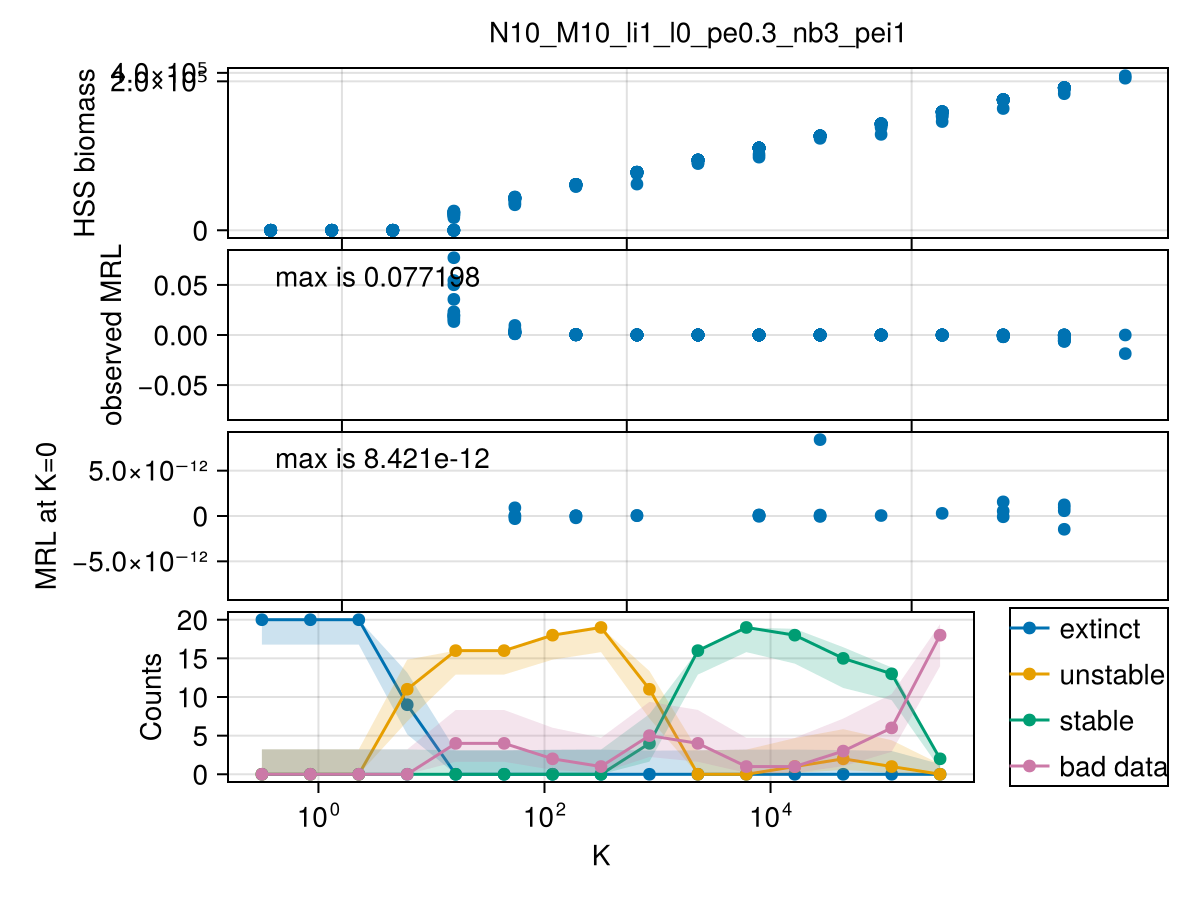

In [20]:
f = plot_df1(df)
Label(f[0,:], pstring; tellwidth=false)
rowsize!(f.layout, 0, Fixed(0.))

Makie.save("../../data/single_influx/gen/$(pstring).pdf", f)
# Makie.save("../../data/single_influx/gen/lcei_$(pstring).pdf", f)
# Makie.save("../../data/single_influx/gen/last.pdf", f)

f

# Small changes from Kabirs setup

In [51]:
function make_counts_df(df)
    probsdf = DataFrame(;
        K=Float64[],
        num_runs=Int[],
        bad_ss=Int[],
        extinct=Int[],
        good_ss_bad_ls=Int[],
        nonext_stable=Int[],
        nonext_unstable=Int[],
    )
    for x in groupby(df, :K)
        K = x.K[1]
        num_runs = nrow(x)
        
        bad_ss = 0
        extinct = 0
        good_ss_bad_ls = 0
        nonext_stable = 0
        nonext_unstable = 0
        for r in eachrow(x)
            if r.sscode == 1
                if r.lscode == 1
                    nonext_stable += 1
                elseif r.lscode == 2
                    nonext_unstable += 1
                else
                    good_ss_bad_ls += 1
                end
            elseif r.sscode == 2
                extinct += 1
            else
                bad_ss += 1
            end
        end
        push!(probsdf, (
            K, num_runs,
            bad_ss,
            extinct,
            good_ss_bad_ls,
            nonext_stable,
            nonext_unstable,
        ))
    end

    probsdf
end

function plot_cdf1!(ax, cdf)
    goodruns = cdf.num_runs .- cdf.bad_ss .- cdf.good_ss_bad_ls
    p1 = plot_binom_sample!(ax, cdf.K, cdf.extinct, goodruns;
        label="extinct"
    )
    # lsruns = cdf.num_runs .- cdf.bad_ss .- cdf.extinct
    p2 = plot_binom_sample!(ax, cdf.K, cdf.nonext_unstable, goodruns;
        label="unstable"
    )
    p3 = plot_binom_sample!(ax, cdf.K, cdf.nonext_stable, goodruns;
        label="stable"
    )
    p3 = plot_binom_sample!(ax, cdf.K, cdf.bad_ss .+ cdf.good_ss_bad_ls, cdf.num_runs;
        label="bad data"
    )
    (p1, p2, p3)
end
function plot_cdf1(cdf)
    f = Figure()
    ax = Axis(f[1,1];
        xlabel="K",
        xscale=log10,
    )
    p = plot_cdf1!(ax, cdf)
    axislegend(ax)
    FigureAxisAnything(f, ax, p)
end

plot_cdf1 (generic function with 1 method)

In [52]:
function plot_df1(df)
    f = Figure(;
        # size=(800, 500)
    )
    
    ax_biom = Axis(f[1,1];
        ylabel="HSS biomass",
        yscale=Makie.pseudolog10,
        # yscale=Makie.log10,
        xscale=log10,
    )
    ax2 = Axis(f[2,1];
        ylabel="observed MRL",
        xscale=log10,
    )
    ax3 = Axis(f[3,1];
        ylabel="MRL at K=0",
        xscale=log10,
    )
    ax4 = Axis(f[4,1];
        ylabel="Counts",
        xscale=log10,
    )
    linkxaxes!(ax_biom, ax4)
    linkxaxes!(ax2, ax4)
    linkxaxes!(ax2, ax4)
    for ax in [ax_biom, ax2, ax3]
        hidexdecorations!(ax;
            grid=false,
            ticks=false,
        )
    end
    ax4.xlabel = "K"
    
    xx = @subset df :good_ss
    # scatter!(ax_biom, xx.K, clamp.(xx.hss_biomass, 1e-20, Inf))
    scatter!(ax_biom, xx.K, xx.hss_biomass)
    
    scatter!(ax2, xx.K, xx.maxmrl)
    maxmaxmrl = maximum(xx.maxmrl)
    ylims!(ax2, (-1.1, 1.1) .* abs(maxmaxmrl))
    text!(ax2, 0.05, 0.75;
        text=(@sprintf "max is %.5g" maxmaxmrl),
        space=:relative,
    )
    
    scatter!(ax3, xx.K, xx.k0mrl)
    maxk0mrl = maximum(xx.k0mrl)
    ylims!(ax3, (-1.1, 1.1) .* abs(maxk0mrl))
    text!(ax3, 0.05, 0.75;
        text=(@sprintf "max is %.5g" maxk0mrl),
        space=:relative,
    )
    
    # display(GLMakie.Screen(), f)
    
    rowgap!(f.layout, 1.)
    plot_cdf1!(ax4, make_counts_df(df))
    axislegend(ax4; position=:lc)

    f
end

plot_df1 (generic function with 1 method)

In [53]:
function plot_df_strain_biomasses(df)
    f = Figure(;
        size=(600, 350)
    )
    ax = Axis(f[1,1];
        xlabel="K",
        ylabel="all strain biomasses",
        xscale=log10,
        yscale=log10,
    )
    
    min_strain_val = minimum(r->minimum(abs, r.steadystates[1:N]), eachrow(df))
    
    for r in eachrow(df)
        scatter!(ax, fill(r.K, N), clamp.(r.steadystates[1:N], min_strain_val, Inf);
            color=Cycled(1),
            marker=:circle
        )
    end
    
    f
end

plot_df_strain_biomasses (generic function with 1 method)

In [57]:
N = 10
M = N

Ks = 10 .^ range(0., 3.5, 21)
# Ks = 10 .^ range(0, 2, 3)

num_repeats = 20
lsks = 10 .^ range(-5, 3, 2000)

# lia = 10.
# lib = 0.1
pei = 1.

# la = 0.1
# lb = 10.

B = 1
pe = B / M
nb = B

# pstring = paramstring(; N, M, lia, lib, la, lb, pe, nb, pei)

cms = []
df = DataFrame(;
    K=Float64[],
    sscode=Int[],
    lscode=Union{Missing,Int}[],
    good_ss=Bool[],
    good_ls=Bool[],
    hss_biomass=Float64[],
    k0mrl=Union{Missing,Float64}[],
    maxmrl=Union{Missing,Float64}[],
    params=Any[],
    steadystates=Vector{Float64}[],
)

@showprogress for K in Ks
    rsg = JansSampler3(N, M;
        K,
        num_influx_resources=1,

        # should be a valid non-dim?
        m=1.,

        # first network layer
        prob_eating_influx=pei,
        linflux=1.,
        # linflux=Beta(lia, lib),
        cinflux=1.,
        
        # rest of the network
        prob_eating=pe,
        l=0.,
        # l=Beta(la, lb),
        # l=Beta(0.5, 0.5),
        c=1.,

        # rest
        num_byproducts=nb, # applies to both!

        Ds=1e-12, Dr=1., Drinflux=1.,
    )

    lst = LinstabScanTester2(rsg.Ns + rsg.Nr, lsks;
        # zerothr=1000*eps(),
    )
    params, sss, sscodes, lsrslts = example_do_rg_run3(rsg, num_repeats, lst;
        maxresidthr=1e-8,
        tol=1e-12,
        doextinctls=true,
        maxiters=1e6,
        timelimit=30,
    )
    
    for i in 1:num_repeats
        sscode = sscodes[i]
        good_ss = (sscode in (1, 2))
        lscode = !isnothing(lsrslts[i]) ? lsrslts[i][1] : missing
        good_ls = !ismissing(lscode) ? (lscode in (1, 2)) : true
        push!(df, (
                K, sscode, lscode, good_ss, good_ls,
                sum(sss[i][1:N]),
                !ismissing(lscode) ? lsrslts[i][2] : missing,
                !ismissing(lscode) ? lsrslts[i][3] : missing,
                params[i], sss[i]
        ))
    end

    codes = Int[]
    for i in 1:num_repeats
        if sscodes[i] == 1
            push!(codes, lsrslts[i][1])
        elseif sscodes[i] == 2
            push!(codes, 101)
        else
            push!(codes, sscodes[i])
        end
    end
    
    cm = countmap(codes)
    push!(cms, cm)

    # push!(cms, sscodes)
end

@show countmap(df.sscode) countmap(df.lscode) count(df.good_ss .&& df.good_ls) / nrow(df)
count(df.good_ss .&& df.good_ls) / nrow(df)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


countmap(df.sscode) = Dict(2 => 199, 1 => 221)
countmap(df.lscode) = Dict{Union{Missing, Int64}, Int64}(22 => 34, 13 => 1, 2 => 101, 11 => 3, 12 => 26, 1 => 238, 23 => 17)
count($(Expr(:.&&, :(df.good_ss), :(df.good_ls)))) / nrow(df) = 0.8071428571428572


0.8071428571428572

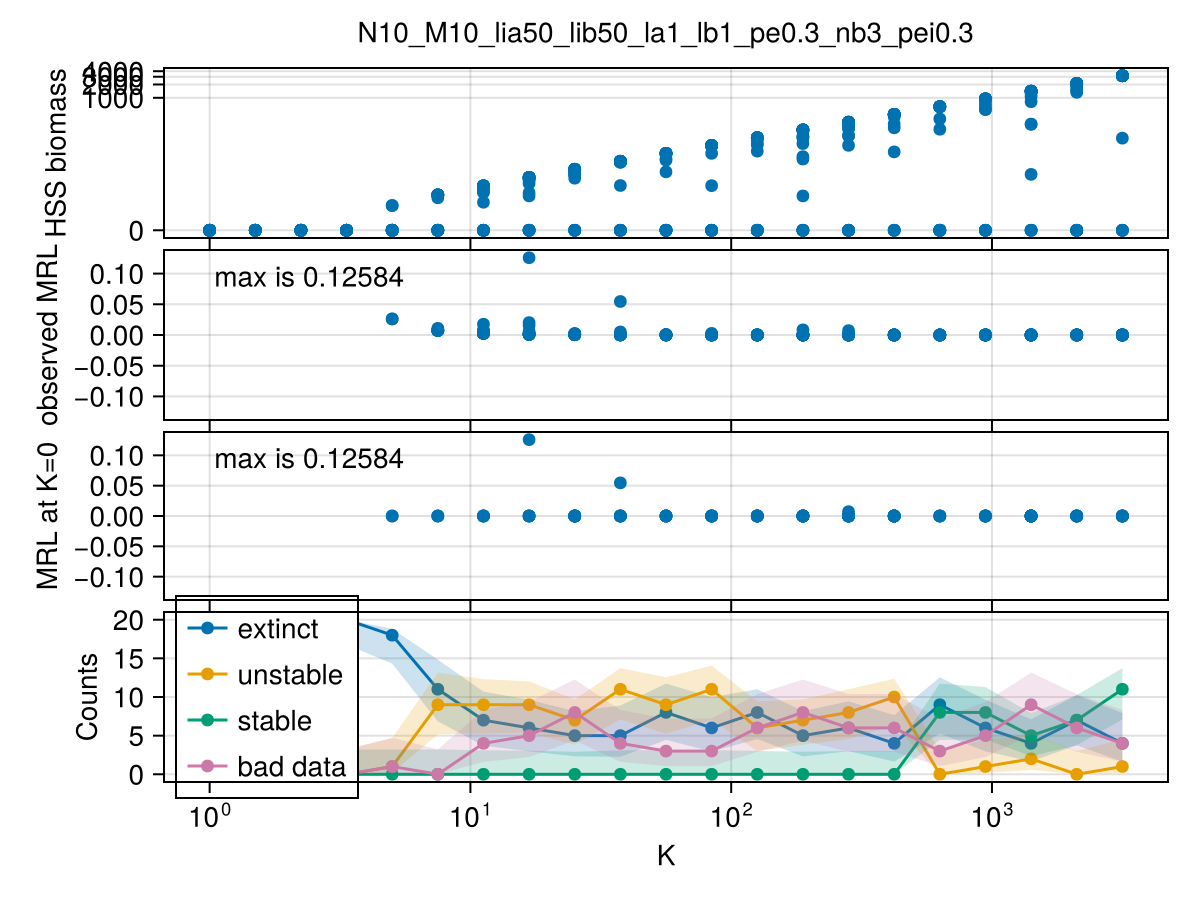

In [58]:
f = plot_df1(df)

Label(f[0,:], pstring; tellwidth=false)
rowsize!(f.layout, 0, Fixed(0.))

# Makie.save("../../data/single_influx/gen/$(pstring).pdf", f)
# Makie.save("../../data/single_influx/gen/last.pdf", f)

f

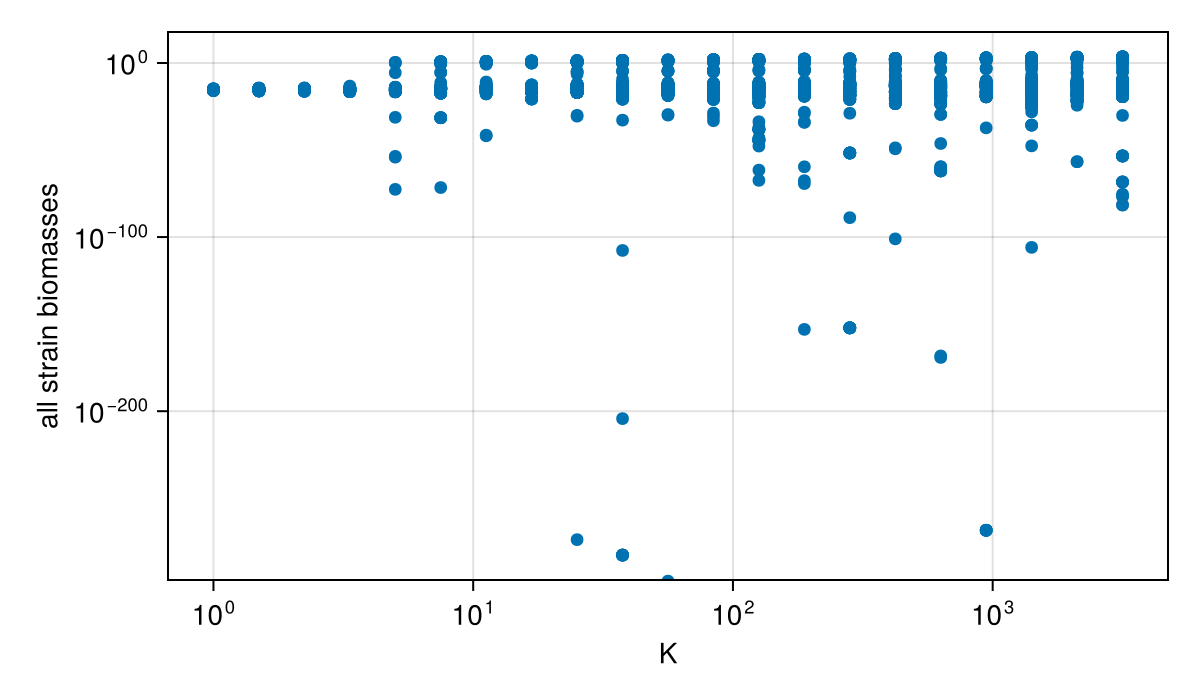

In [59]:
plot_df_strain_biomasses(df)

In [68]:
df.sssurvivors = [count(ss[1:N] .> 1e-8) for ss in df.steadystates];
# scatter(df.sssurvivors, df.lscode)

In [70]:
countmap(df.sssurvivors)

Dict{Int64, Int64} with 8 entries:
  0 => 199
  4 => 20
  5 => 22
  6 => 3
  2 => 45
  7 => 1
  3 => 45
  1 => 85

# Doing exactly Kabirs setup

In [289]:
function make_counts_df(df)
    probsdf = DataFrame(;
        K=Float64[],
        num_runs=Int[],
        bad_ss=Int[],
        extinct=Int[],
        good_ss_bad_ls=Int[],
        nonext_stable=Int[],
        nonext_unstable=Int[],
    )
    for x in groupby(df, :K)
        K = x.K[1]
        num_runs = nrow(x)
        
        bad_ss = 0
        extinct = 0
        good_ss_bad_ls = 0
        nonext_stable = 0
        nonext_unstable = 0
        for r in eachrow(x)
            if r.sscode == 1
                if r.lscode == 1
                    nonext_stable += 1
                elseif r.lscode == 2
                    nonext_unstable += 1
                else
                    good_ss_bad_ls += 1
                end
            elseif r.sscode == 2
                extinct += 1
            else
                bad_ss += 1
            end
        end
        push!(probsdf, (
            K, num_runs,
            bad_ss,
            extinct,
            good_ss_bad_ls,
            nonext_stable,
            nonext_unstable,
        ))
    end

    probsdf
end

function plot_cdf1!(ax, cdf)
    goodruns = cdf.num_runs .- cdf.bad_ss .- cdf.good_ss_bad_ls
    p1 = plot_binom_sample!(ax, cdf.K, cdf.extinct, goodruns;
        label="extinct"
    )
    # lsruns = cdf.num_runs .- cdf.bad_ss .- cdf.extinct
    p2 = plot_binom_sample!(ax, cdf.K, cdf.nonext_unstable, goodruns;
        label="unstable"
    )
    p3 = plot_binom_sample!(ax, cdf.K, cdf.nonext_stable, goodruns;
        label="stable"
    )
    (p1, p2, p3)
end
function plot_cdf1(cdf)
    f = Figure()
    ax = Axis(f[1,1];
        xlabel="K",
        xscale=log10,
    )
    p = plot_cdf1!(ax, cdf)
    axislegend(ax)
    FigureAxisAnything(f, ax, p)
end

plot_cdf1 (generic function with 2 methods)

In [313]:
N = 10
M = N

Ks = 10 .^ range(0., 3., 21)
# Ks = 10 .^ range(0, 2, 3)

num_repeats = 20
kmax, numks = 50, 1000

cms = []
df = DataFrame(;
    K=Float64[],
    sscode=Int[],
    lscode=Union{Missing,Int}[],
    good_ss=Bool[],
    good_ls=Bool[],
    hss_biomass=Float64[],
    k0mrl=Union{Missing,Float64}[],
    maxmrl=Union{Missing,Float64}[],
    params=Any[],
    steadystates=Vector{Float64}[],
)

@showprogress for K in Ks
    rsg = JansSampler3(N, M;
        K,
        num_influx_resources=1,

        # should be a valid non-dim?
        m=1.,

        # first network layer
        prob_eating_influx=1.,
        linflux=1.,
        # linflux=Beta(10.,0.01),
        # linflux=Beta(10.,0.1),
        # linflux=Beta(0.5,0.5),
        cinflux=1.,
        
        # rest of the network
        prob_eating=0.1,
        # l=Beta(0.5, 0.5),
        l=0.,
        c=1.,

        # rest
        num_byproducts=4, # applies to both!

        Ds=1e-12, Dr=1., Drinflux=1.,
    )

    lst = LinstabScanTester2(rsg.Ns + rsg.Nr, 50., 1000;
        # zerothr=1000*eps(),
    )
    params, sss, sscodes, lsrslts = example_do_rg_run3(rsg, num_repeats, lst;
        maxresidthr=1e-8,
        tol=1e-13,
        doextinctls=true,
        maxiters=1e5,
        timelimit=10,
    )
    
    for i in 1:num_repeats
        sscode = sscodes[i]
        good_ss = (sscode in (1, 2))
        lscode = !isnothing(lsrslts[i]) ? lsrslts[i][1] : missing
        good_ls = !ismissing(lscode) ? (lscode in (1, 2)) : true
        push!(df, (
                K, sscode, lscode, good_ss, good_ls,
                sum(sss[i][1:N]),
                !ismissing(lscode) ? lsrslts[i][2] : missing,
                !ismissing(lscode) ? lsrslts[i][3] : missing,
                params[i], sss[i]
        ))
    end

    codes = Int[]
    for i in 1:num_repeats
        if sscodes[i] == 1
            push!(codes, lsrslts[i][1])
        elseif sscodes[i] == 2
            push!(codes, 101)
        else
            push!(codes, sscodes[i])
        end
    end
    
    cm = countmap(codes)
    push!(cms, cm)

    # push!(cms, sscodes)
end

@show countmap(df.sscode) countmap(df.lscode) count(df.good_ss .&& df.good_ls) / nrow(df)
count(df.good_ss .&& df.good_ls) / nrow(df)

Progress:  33%|█████████████▋                           |  ETA: 0:00:27┌ Warning: Solver quit due to time limit being reached
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:356
┌ Warning: Solver quit due to time limit being reached
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:356
┌ Warning: Solver quit due to time limit being reached
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:356
┌ Warning: Solver quit due to time limit being reached
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:356
┌ Warning: Solver quit due to tim

countmap(df.sscode) = Dict(1015 => 7, 2 => 153, -2000 => 2, 1 => 258)
countmap(df.lscode) = Dict{Union{Missing, Int64}, Int64}(22 => 1, 23 => 2, 2 => 95, 11 => 24, 12 => 40, 1 => 249, missing => 9)
count($(Expr(:.&&, :(df.good_ss), :(df.good_ls)))) / nrow(df) = 0.819047619047619


0.819047619047619

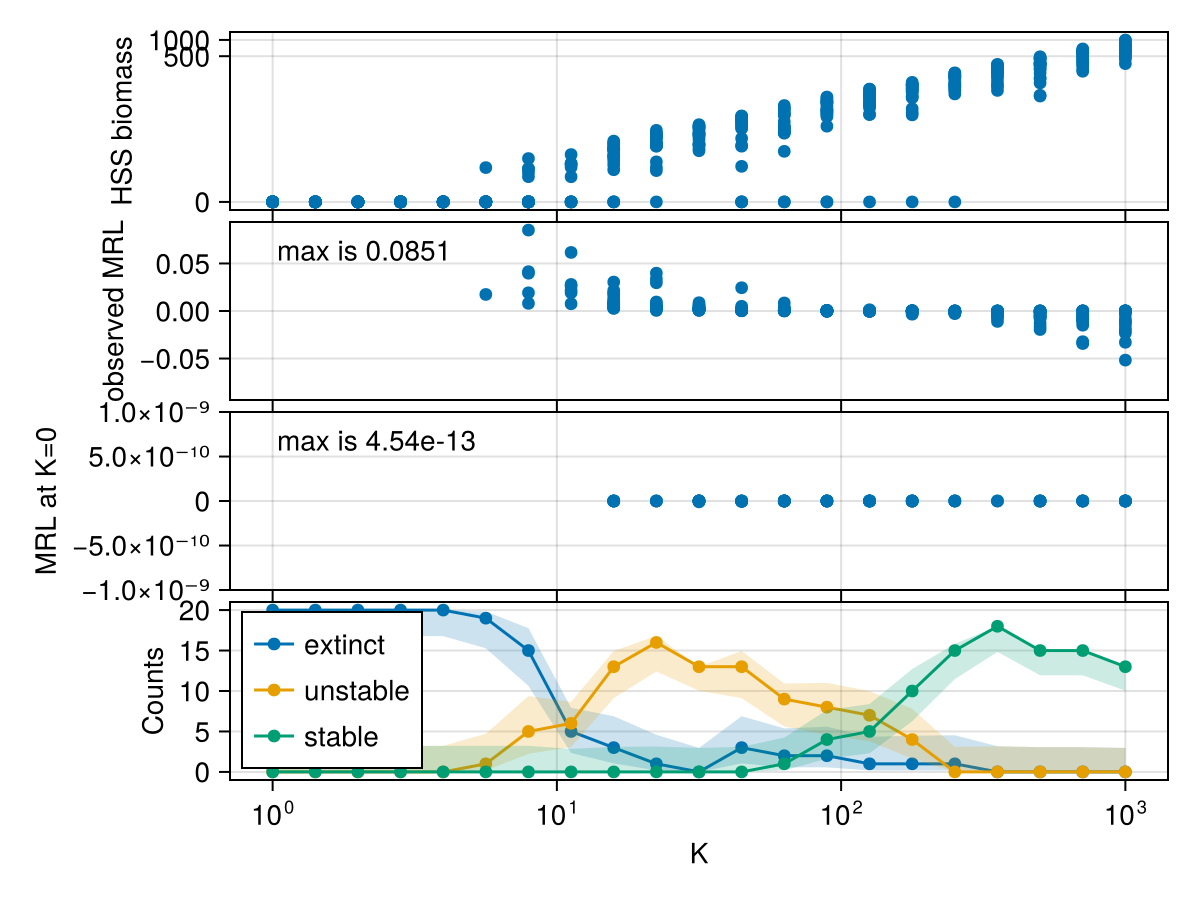

In [314]:
f = Figure(;
    # size=(800, 500)
)

ax_biom = Axis(f[1,1];
    ylabel="HSS biomass",
    yscale=Makie.pseudolog10,
    # yscale=Makie.log10,
    xscale=log10,
)
ax2 = Axis(f[2,1];
    ylabel="observed MRL",
    xscale=log10,
)
ax3 = Axis(f[3,1];
    ylabel="MRL at K=0",
    xscale=log10,
)
ax4 = Axis(f[4,1];
    ylabel="Counts",
    xscale=log10,
)
linkxaxes!(ax_biom, ax4)
linkxaxes!(ax2, ax4)
linkxaxes!(ax2, ax4)
for ax in [ax_biom, ax2, ax3]
    hidexdecorations!(ax;
        grid=false,
        ticks=false,
    )
end
ax4.xlabel = "K"

xx = @subset df :good_ss
# scatter!(ax_biom, xx.K, clamp.(xx.hss_biomass, 1e-20, Inf))
scatter!(ax_biom, xx.K, xx.hss_biomass)

scatter!(ax2, xx.K, xx.maxmrl)
maxmaxmrl = maximum(xx.maxmrl)
ylims!(ax2, (-1.1, 1.1) .* maxmaxmrl)
text!(ax2, 0.05, 0.75;
    text=(@sprintf "max is %.3g" maxmaxmrl),
    space=:relative,
)

scatter!(ax3, xx.K, xx.k0mrl)
text!(ax3, 0.05, 0.75;
    text=(@sprintf "max is %.3g" maximum(xx.k0mrl)),
    space=:relative,
)
ylims!(ax3, (-1, 1) .* 1e-9)

# display(GLMakie.Screen(), f)

rowgap!(f.layout, 1.)
plot_cdf1!(ax4, make_counts_df(df))
axislegend(ax4; position=:lc)

f

# Testing

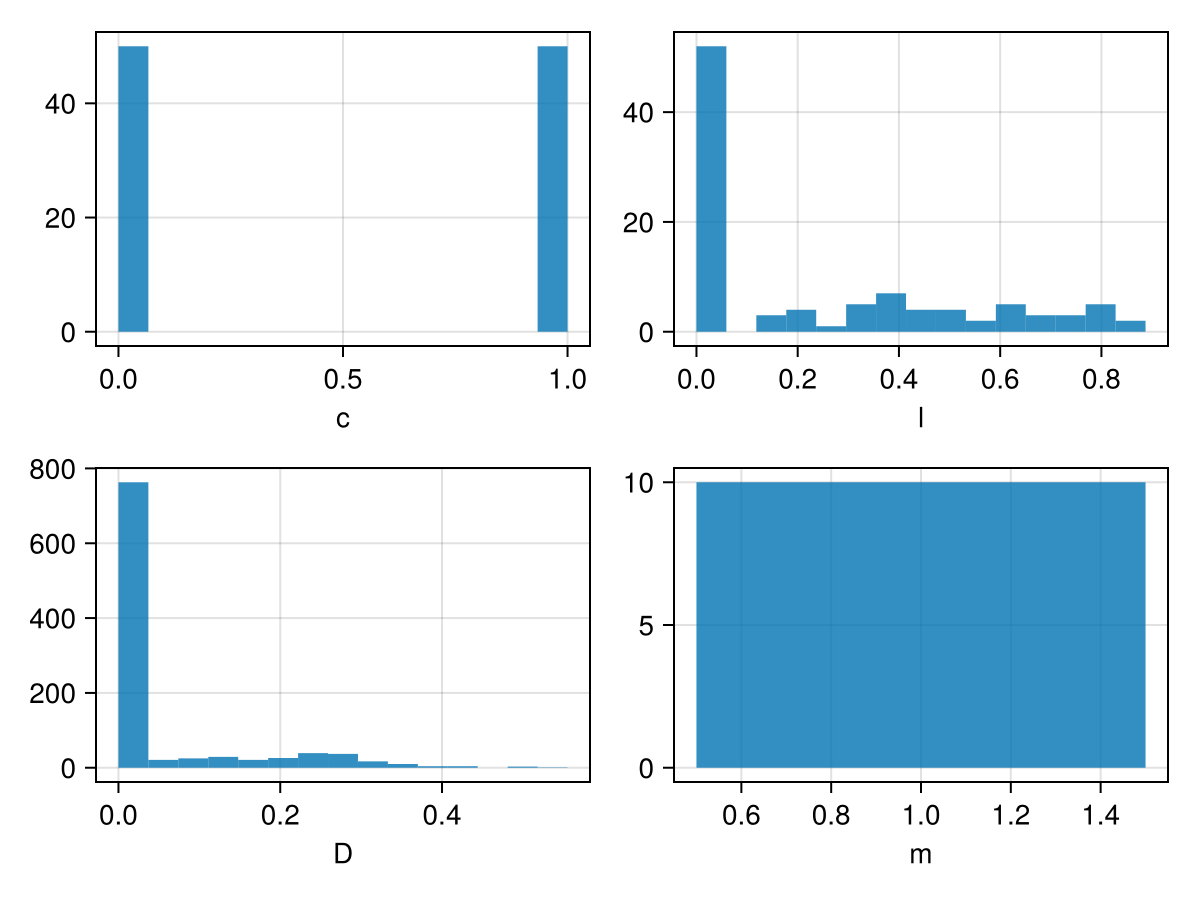

In [7]:
rsg = get_rsg_unimodalc(10;
    K=2,
    # linflux=1.
)

rsg_stats1(rsg)

In [8]:
@time rslt = example_do_rg_run2(rsg, 100, 50, 1000);
cm = countmap(rslt)

 11.078366 seconds (27.14 M allocations: 5.360 GiB, 3.04% gc time, 1537.87% compilation time: <1% of which was recompilation)


Dict{Int64, Int64} with 2 entries:
  1   => 98
  101 => 2

In [10]:
rsg = JansSampler3(10, 10;
    m=1.,
    K=100.,
    num_influx_resources=1,
    
    prob_eating=0.1,
    num_byproducts=4,
    # l=Beta(0.5, 0.5),
    l=0.,
    c=1.,
    
    prob_eating_influx=1.,
    # linflux=1.,
    linflux=Beta(10.,0.01),
    # linflux=Beta(0.5,0.5),
    cinflux=1.,
)

rsg_stats1(rsg);

In [23]:
instability_stats(cm)

(0.6966292134831461, (0.5946286603942714, 0.7823580914791124))

In [11]:
rslt = example_do_rg_run2(rsg, 100, 50, 1000);
cm = countmap(rslt)

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase ~/.julia/packages/SciMLBase/m1Jrs/src/integrator_interface.jl:589


Dict{Int64, Int64} with 6 entries:
  22    => 8
  101   => 2
  2     => 62
  -1004 => 1
  1     => 25
  23    => 2

# Running a single system

In [108]:
ps = rsg();
# ps = ms();

LoadError: UndefVarError: `rsg` not defined

In [162]:
# i = rand(findall((df.sscode .== 1) .&& isapprox.(df.K, 1.5; atol=0.1)))
# i = rand(findall(df.lscode .=== 2)) # unstable system
# i = rand(findall((df.lscode .=== 1) .&& (df.sscode .== 1))) # nonext stable system
# i = rand(findall(df.sscode .== -2000))
i = rand(findall(df.sssurvivors .== 7))
dfr = df[i,:]
ps = dfr.params;
dfr

Row,K,sscode,lscode,good_ss,good_ls,hss_biomass,k0mrl,maxmrl,params,steadystates,sssurvivors
,Float64,Int64,Int64?,Bool,Bool,Float64,Float64?,Float64?,Any,Array…,Int64
242,125.893,1,22,true,false,113.553,3.31449e-13,7.03181e-5,"BSMMiCRMParams{Nothing, Nothing, Nothing, Float64}(BMMiCRMParams{Nothing, Float64}([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 125.893, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 1.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 0.0;;; 1.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], nothing), [1.0e-12, 1.0e-12, 1.0e-12, 1.0e-12, 1.0e-12, 1.0e-12, 1.0e-12, 1.0e-12, 1.0e-12, 1.0e-12, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], nothing, nothing)","[1.0842e-13, 6.58874, 1.0842e-13, 12.9004, 6.58874, 1.0842e-13, 24.3867, 12.9004, 25.8008, 24.3867, 4.545e-12, 1.0, 1.09899, 1.0, 0.0, 0.0, 1.0, 1.0, 7.24098, 0.0]",7


## No space solver

  0.001348 seconds (428 allocations: 80.594 KiB)
sort((s.u[end])[1:N]; rev = true) = [25.859509414993166, 24.46099630137437, 24.459801805622142, 13.097425681099269, 12.76077211234309, 6.506012382824172, 6.506012085484335, 4.9819320590046306e-30, 2.8927995888216e-63, -8.365055911323962e-161]


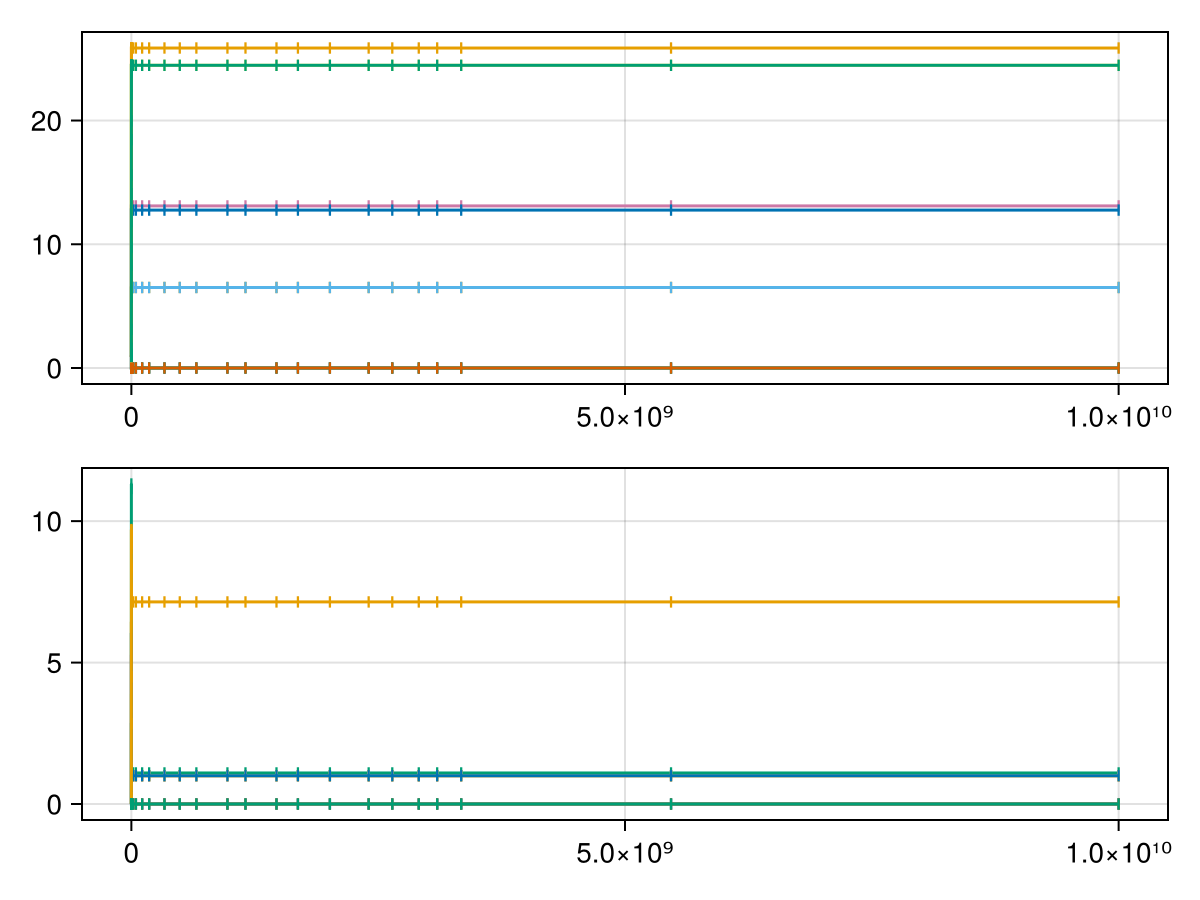

In [163]:
# Fixed time with evolution
u0 = make_u0_smart(ps; u0=:onlyN);
p = make_mmicrm_problem(ps, u0, 10000000000);
# p = remake_guarantee_positive(p)

@time s = solve(p, TRBDF2();
    callback=make_timer_callback(1.)
)

@show sort(s.u[end][1:N]; rev=true)

f = plot_mmicrm_sol(s)
# display(GLMakie.Screen(), f)
f

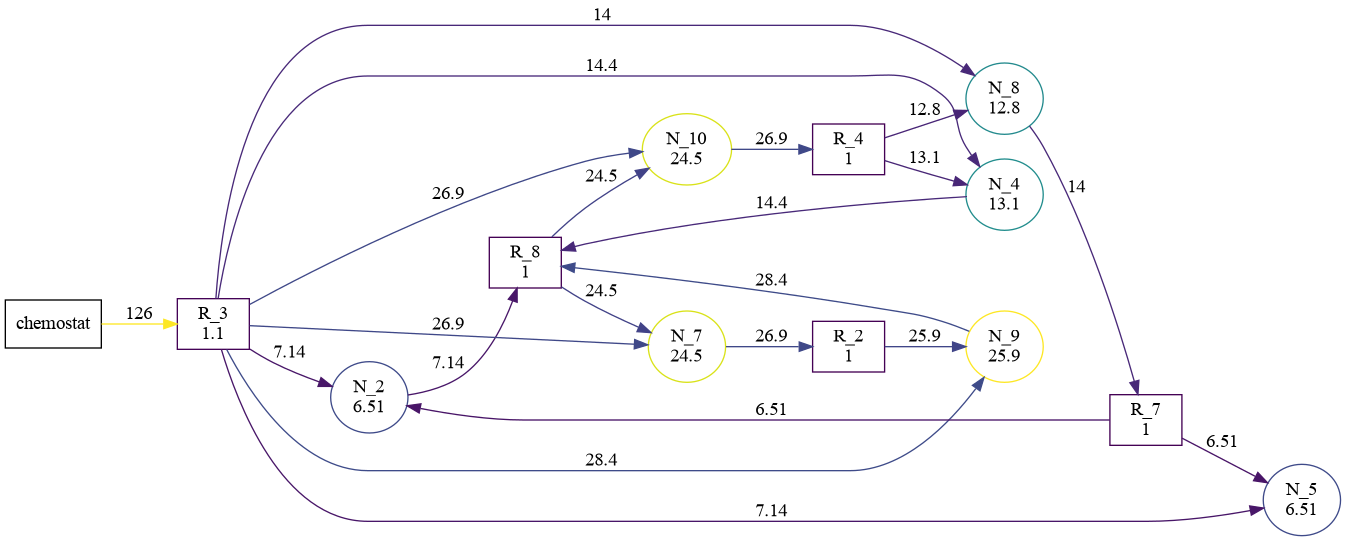

In [164]:
diagram_sfss_v3(ps, clamp.(s.u[end], minimum(abs, s.u[end]), Inf);
    strain_threshold=1e-3,
    # colorscale=log10,
)

In [149]:
# Steady state
u0 = make_u0_smart(ps; u0=:onlyN)
ssp = make_mmicrm_ss_problem(ps, u0)
@time sss = solve(ssp, DynamicSS(QNDF());
    abstol=eps(),
    reltol=eps(),
    callback=make_timer_callback(10),
);
maximum(abs, sss.resid)

 14.477851 seconds (9.27 M allocations: 811.985 MiB, 25.07% gc time, 42.08% compilation time)


1.6579350071639944e-12

## Spatial stuff

In [118]:
nssol = s.u[end];
# nssol = sss.u
xx = uninplace(mmicrmfunc!)(nssol, ps)
maxresid = maximum(abs, xx)
@show maxresid;

maxresid = 2.2737367544323206e-13


### Linear stability

In [380]:
# ks = LinRange(0., 50., 10000)
# ks = lsks
ks = 10 .^ range(-5, 5, 2000)

Ds = get_Ds(ps)
# Ds = vcat(
#     fill(1e-8, get_Ns(ps)[1]),
#     fill(1e-8, get_Ns(ps)[2])
# )
# Ds[20] = 10000

lamfunc = linstab_make_k_func(ps, Ds, nssol)
lambdas = lamfunc.(ks);

maximum(x->maximum(real, x), lambdas)

0.0001301885064772557

In [381]:
xx = LinstabScanTester2(ps, 50., 1000)
xx(ps, nssol)

(2, -0.02617729569943119, 0.0001290439236254262, true)

[ Info: Unstable, mrl is 0.000130189


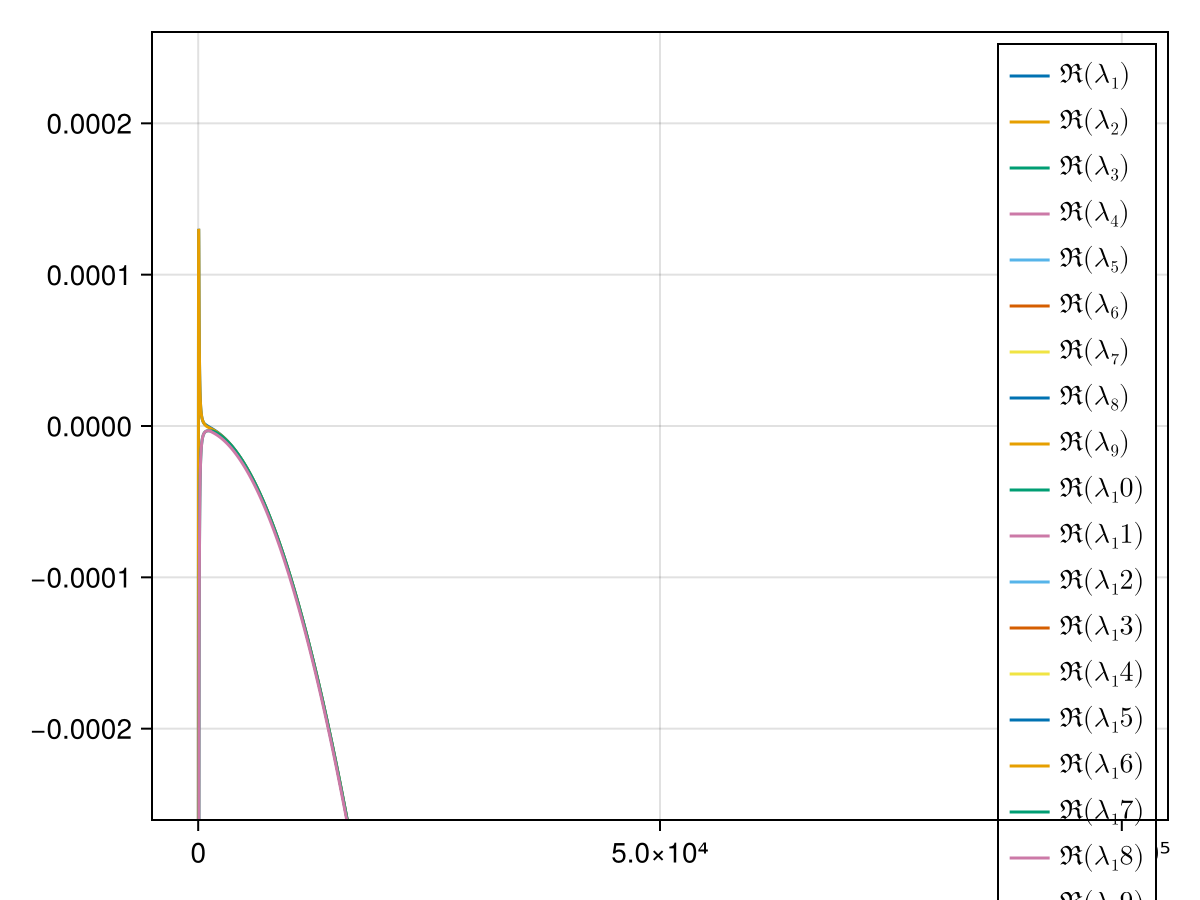

In [382]:
faa = plot_linstab_lambdas(ks, lambdas;
    imthreshold=Inf
)
# display(GLMakie.Screen(), faa.figure)
kk = abs(maximum(x->maximum(real, x), lambdas))
ylims!(faa.axis, (-2., 2.) .* kk)
# xlims!(faa.axis, 0., 1000)
faa

### 1D spatial

In [349]:
ssize = (1000,)
dx = 0.01

# baseu0 = nssol
baseu0 = make_u0_smart(ps; u0=:onlyN)
su0 = expand_u0_to_size(ssize, baseu0)
su0 = perturb_u0_uniform_prop(get_Ns(ps)..., su0, 0.1, 0.1)


spaceps = change_bsmmicrmparams(ps; space=make_cartesianspace_smart(1;
    dx,
    bcs=Periodic()),
    usenthreads=nthreads()
)
@show spaceps.usenthreads spaceps.mmicrm_params.usenthreads

sp = make_smmicrm_problem(spaceps, su0, 100000);

spaceps.usenthreads = 18
spaceps.mmicrm_params.usenthreads = nothing


In [350]:
@time sps = solve(sp, QNDF());
print_spatial_solution_stats(sps)

  9.385754 seconds (13.18 M allocations: 3.611 GiB, 2.23% gc time, 129.82% compilation time)
Success
nf is 1030
solution has 155 saved states
max resid is 2.55048e-06


┌ Warning: reaching negative values, minimum is -3.34381e-07
└ @ SSMCMain.ModifiedMiCRM ~/UCLOneDrive/Projects/SSMC/src/SSMCMain/src/ModifiedMiCRM/util.jl:10


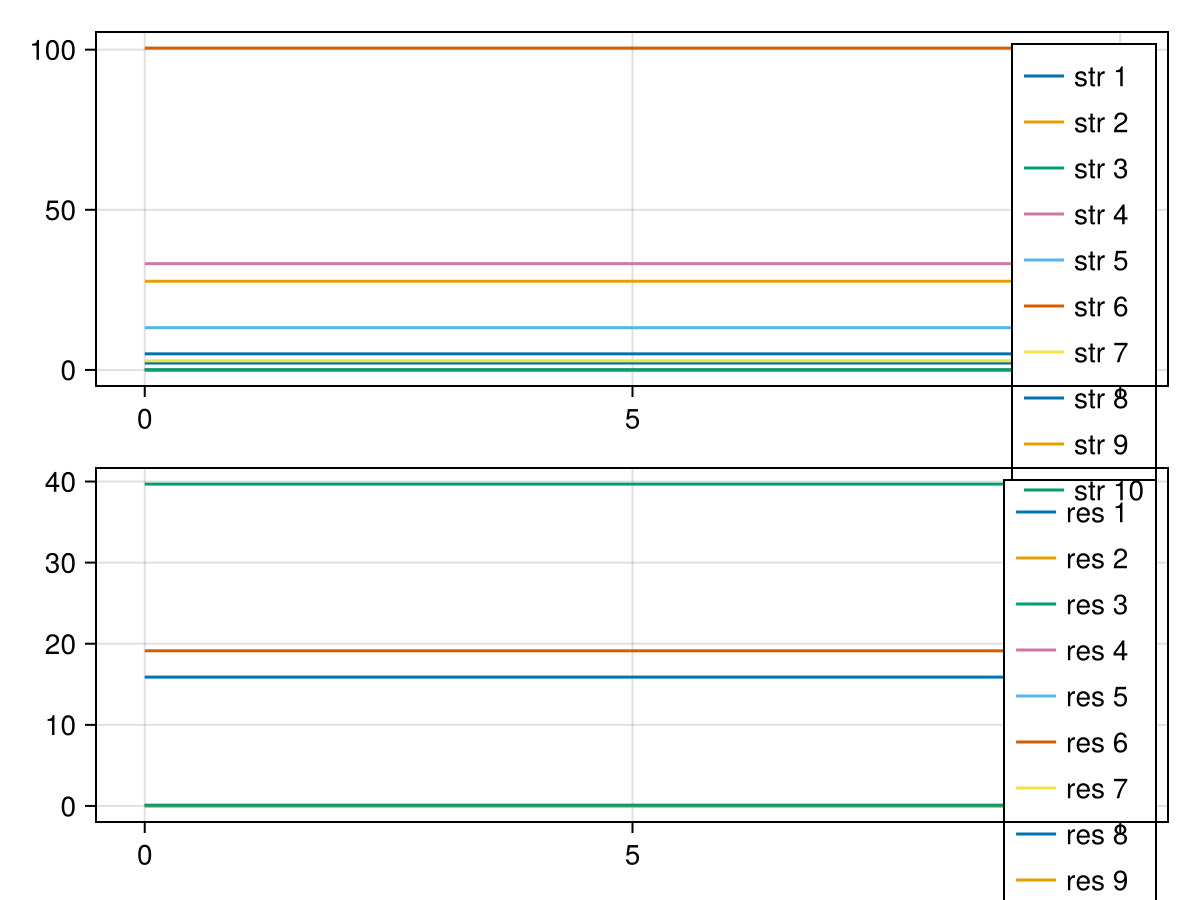

In [352]:
plot_1dsmmicrm_sol_snap(sps.prob.p, sps.u[end])

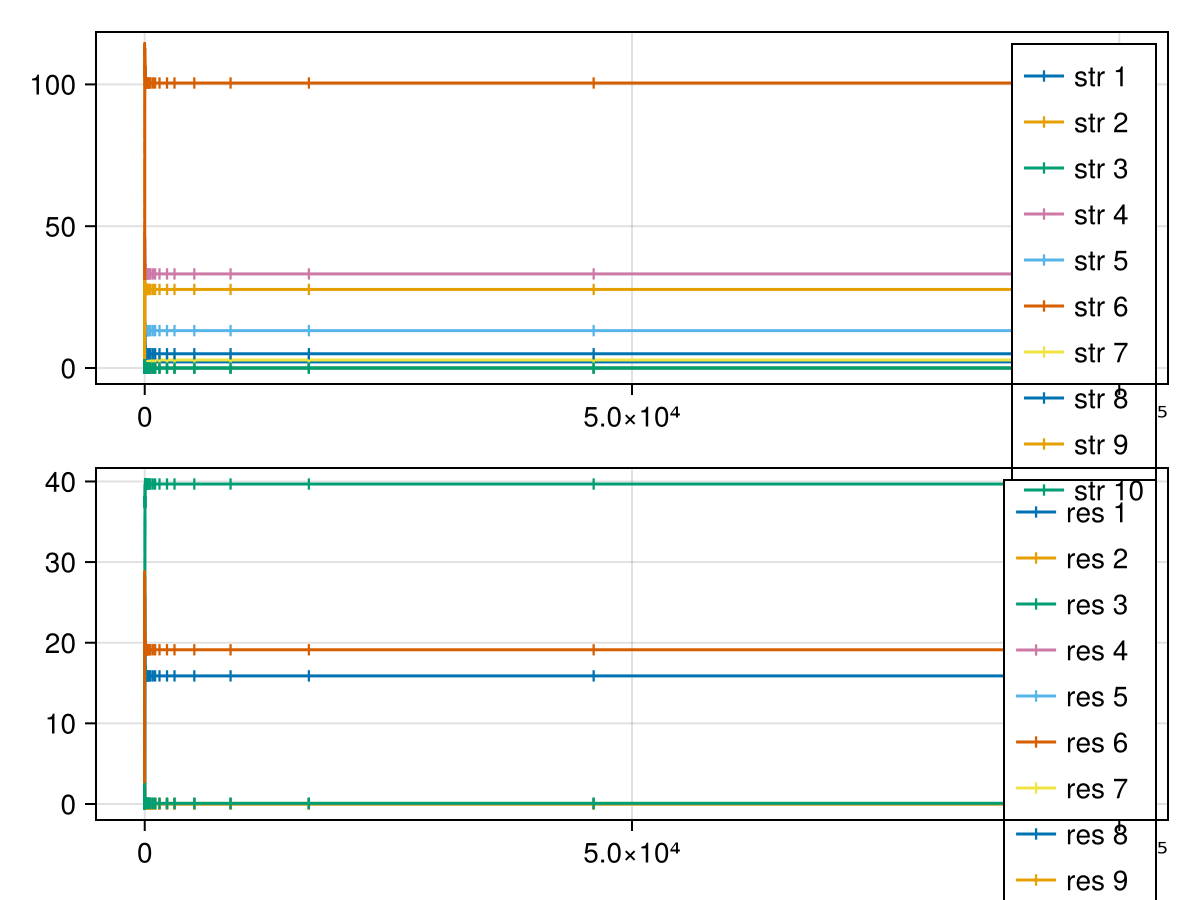

In [353]:
plot_smmicrm_sol_avgs(sps)

# Extras

In [189]:
GC.gc()
empty!(Out)
GC.gc()